In [246]:
#### load python packages ####
import os
import pathlib
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, sem, t, norm
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm

## Setup

### Set up rpy2 and import packages

In [247]:
# For detailed rpy2 instructions, see the documentation: https://rpy2.github.io/doc/latest/html/index.html
# Generally it can be a hassle installing for the first time, but once you have it running it won't give you problems
#### setup rpy2 ####
# run once at start of session
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [248]:
#### import robjects and other necessary packages for rpy2 setup ####
import rpy2.ipython.html
import tzlocal
import rpy2.robjects as robjects
from rpy2.robjects import r

rpy2.ipython.html.init_printing()

In [249]:
# You may need to install the R kernel for jupyter lab if this is your first time using rpy2. If so, try this (you only need to run it once):
# install.packages('IRkernel')
# IRkernel::installspec()

In [250]:
#### import more necessary packages for rpy2 setup ####
# import rpy2's package module
from rpy2.robjects.packages import importr
# import R's utility package
utils = importr('utils')
# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # selects the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x16b1d5c00> [RTYPES.NILSXP]

In [251]:
## Check version of R that rpy2 is using 
robjects.r['version']

0,platform,[1]...
1,arch,"[1] ""x86_64"""
2,os,[1]...
3,system,[1]...
4,status,"[1] """""
5,major,"[1] ""4"""
6,minor,"[1] ""1.3"""
7,year,"[1] ""2022"""
...,...,...
12,version.string,"[1] ""R..."
13,nickname,"[1] ""One..."


In [252]:
## If you need to install certain R packages, use the following syntax (here we're installing 'tidyverse'):
# utils.install_packages('gridExtra')

In [253]:
%%R
# ^if you ever want to run R code with rpy2, you need the "%%R" at the very top of the cell. 
## load your normal R packages ##
library(GGally)
library(tidyverse)
library(ggpubr)
library(repr)
library(ragg)
library(gridExtra)

# Set plot window size
options(repr.plot.width=20, repr.plot.height=8)

## Set working directories

In [254]:
##### Set a working directory where you want the output CSVs and plots from this analysis to go #####
working_dir = "~/Documents/Documents_Primary/Labs/Github/pmc_face/ofc_imp_analysis/Hastings_OFC_BenUpdate/Hastings_OFC_6_26_24/"
# working_dir = "/Users/benparker/Desktop/cnl/Urgency/projects/Hastings_OFC/"
working_dir = os.path.expanduser(working_dir)

In [255]:
### This notebook will create a folder called "lasso_output" with folders for CSV files and plots outputted from this notebook
### The folder will be created in the working directory you specified above
csv_path = os.path.join(working_dir, "lasso_output/CSVs")
# plt_path = os.path.join(working_dir, "lasso_output/plots")

os.makedirs(csv_path, exist_ok=True)
# os.makedirs(plt_path, exist_ok=True)

In [256]:
%%R

# set current working directory for R code
setwd("~/Documents/Documents_Primary/Labs/Github/pmc_face/ofc_imp_analysis/Hastings_OFC_BenUpdate/Hastings_OFC_6_26_24/")
getwd()

[1] "/Users/josephkelly/Documents/Documents_Primary/Labs/Github/pmc_face/ofc_imp_analysis/Hastings_OFC_BenUpdate/Hastings_OFC_6_26_24"


In [257]:
# Set viewing options (# of rows, # of columns, column width) for when you call a python (pandas) dataframe in this notebook
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

### R plot functions for LASSO heatmap and scatterplot

In [258]:
%%R

#### Functions for Plotting Lasso and MSE ####

# Set the main color for your plots
plt_color = "#D25727"


plt_lasso <- function(lasso_coefs) {    
    
    lasso_coef_plt <- ggplot(data = lasso_coefs, aes(x=as.factor(alpha_level), y=as.factor(Sulci))) +
      # tile plot
      geom_tile(aes(fill = beta), size=0.3) +
    # set coordinates
      coord_equal() +
      scale_y_discrete(limits = rev(levels(lasso_coefs$Sulci))) +
    # set color gradient, pick your favorite colors!
      scale_fill_gradient2(limits= c(-0.25, 0.25), n.breaks = 5,
                           low = scales::muted("blue"), mid = "white", high = scales::muted("red"),
                           midpoint = 0, space = "Lab", na.value = "grey50",
                           guide = "colourbar", aesthetics = "fill") +

    # set text object and axis labels
      geom_text(aes(label=round(beta, digits = 2),
                    size = 2), size = 4) +
      xlab("alpha level") +
      ylab('OFC Sulcus') + # change for region + hemisphere
      labs(fill = "beta") +    
    
      scale_x_discrete(position = "top") +
    
    # set theme
      theme(
        # set axis title
        axis.title.x = element_text(color="#333333",
                                    size=12),
        axis.title.y = element_text(color="#333333",
                                    angle=90,size=14),
        # set axis text
        axis.text = element_text( color='#333333',
                                  size = 12),
        axis.text.x = element_text(angle = 45, hjust = 0),
        # set panel
        panel.border = element_rect(colour = "black",
                                    fill=NA, size=1),
        # set legend
        legend.title = element_text(color="#333333",size = 12),
        legend.text = element_text( color = '#333333',size = 12),
        axis.line = element_blank(),
        axis.ticks = element_blank()
      )

    lasso_coef_plt
    
}


## plt_MSE function
plt_mse <- function(df, show_all_alphas=FALSE) {
    
#     df$alpha <- log10(df$alpha)
    
  MSE <- (ggplot(df, aes(x=alpha, y=MSE)) +       
             # add smooth line
             geom_smooth( color = "#0072B2" ,
                          span = 0.55,          # This controls how smoothed or "wiggly" your line is
                          se = FALSE, 
                          linewidth = 2,
                          method = "loess") +             
             # vertical line to indiciate lowest MSE at best alpha level
             geom_vline(xintercept = df$alpha[df$MSE == min(df$MSE)], 
                            linetype="dotted", 
                            size = 1.5) +

           # axis labels
#              xlab ('log(\u03B1)')+
#              xlab('\u03B1') +
             xlab('') +
             ylab(bquote(MSE[CV]))+
          
#              scale_x_log10() +
#              ylim(NA, .53) +
#              scale_x_continuous(breaks = c(.000, .025, .050, .075, .100, .125)) +
             scale_x_continuous(
                 breaks = unique(df$alpha), 
             ) +
          
             # set theme
             theme_classic() +
             # customize theme
             theme(
               # set axis title
               axis.title.x = element_text(color="#333333",
                                           size=12),
               axis.title.y = element_text(color="#333333",
                                           angle=90,size=12),
               # set axis text
               axis.text = element_text( color='#333333',
                                         size = 12 ,hjust =0),
               axis.text.x = element_blank(),
               axis.ticks.x = element_blank(),
                 
               # set lengend
               legend.text = element_text( color = '#333333',
                                           size = 12),
               # set panel
               panel.grid.minor=element_blank(),
               legend.title = element_text(color="#333333",
                                           size = 12),
               panel.border = element_rect(colour = "black",
                                           fill=NA, linewidth=1),
               # set aspect ratio
               aspect.ratio = 10/25
             )
  )
  
  if (show_all_alphas==TRUE) {
    
    for (a in df$alpha) {
      MSE <- MSE + geom_vline(xintercept = df$alpha[df$alpha == a], 
                                linetype="dotted", 
                                linewidth = 1) +
        annotate(x=a, y=+Inf, label=a, geom="text", hjust=2, vjust=1.3, angle=90, size=3.5) +
        geom_point(color="red")
      
    }
  } else {
      MSE <- MSE
  }
    
  MSE
}


In [259]:
%%R

scatter_plot <- function(ggplot_object, color_){
  
  # set theme
  scattertheme = theme(
    # plot title
    plot.title = element_text(size = 26, hjust=0),
    # axis title
    axis.title = element_text(size =18),
    # axis text
    axis.text = element_text(size = 18),
    # legend 
    legend.title = element_blank(),
    # set pannel
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank()) 
  
  plot = ggplot_object + 
    # set regression line
    geom_smooth(aes(y=Predicted),
                # linear reg line
                method="lm",
                # incl. standard error
                se=TRUE,
                fill="gray",
                #line asthetics
                color=color_, 
                alpha=0.5, 
                linetype="dotted") + 
    # set points 
    geom_point(shape = 19, 
               size = 2,
               color = color_ ) + 
    # replace classic theme with these settings
    theme_classic() %+replace% scattertheme
  
  return(plot + stat_cor(geom = "label",
                         method="spearman", 
                         p.accuracy = .001, size = 7,
                         label.x.npc = 0.53,
                         label.y.npc = c(0.1, 0.1),
                         ))
}


### Analysis functions (LASSO)

In [260]:
## Initialize df that will hold all the dataframes from lasso analyses
lasso_df_dict = {}
# initialize leave-one-out cross-validation (LOOCV)
loo = LeaveOneOut()

In [261]:
## Lasso ##
def lasso_cv(Xr, yr, alpha_vals, n_folds = loo):
    ''''
        Determine best parameters for LASSO regression and fit model. Then, with the model selected from the LASSO,
        perform linear regression with a leave-one-subject-out cross-validation procedure. 
        input
        ----------
        Xr = matrix or array of predictors from dataframe  in format Xr= df[['X1', 'X2', 'Xn']] 
        yr = Array of DV of interest from dataframe in format yr= df['y']
        alpha_vals = array of possible alpha values to test 
        n_folds = folds for cross-validation. Default is loo
        Returns
        --------
        dict with model characteristics and performance statistics  
        
        NOTE: This is the only function you need to run the fully nested LASSO.
            The lasso_analysis function below is just for making output files, which become necessary for plotting.    
    '''
    
#     Standardize features for LASSO
    Xr_scaled = StandardScaler().fit_transform(Xr)
    Xr = pd.DataFrame(Xr_scaled, columns = Xr.columns)
    # determine the alpha-value that minimizes MSE with GridSearchCV.
    lasso = Lasso()
    lasso_regressor = GridSearchCV(lasso, alpha_vals, scoring = 'neg_mean_squared_error', cv = loo, n_jobs=4)
    lasso_regressor.fit(Xr, yr)
    # best alpha and MSE from grid search
    best_grid_alpha = lasso_regressor.best_params_
    best_grid_MSE = lasso_regressor.best_score_ * -1
    best_model = lasso_regressor.best_estimator_

    import warnings
    with warnings.catch_warnings():  
        warnings.filterwarnings("ignore", 
                                message="X has feature names, but SelectFromModel was fitted without feature names")
        warnings.filterwarnings("ignore", 
                                message="No features were selected: either the data is too noisy or the selection test too strict.")
        
        lasso_regressor = best_model.fit(Xr,yr)
        model = SelectFromModel(lasso_regressor, prefit=True)   # selects the features from the fitted LASSO 
        feature_idx = model.get_support()
        feature_names = Xr.columns[feature_idx].to_numpy()
        X_new = model.transform(Xr)     # filter original feature data to only includes selected features

    Xr = X_new.copy()
    Xtests = []
    ytests = []
    ypreds = []
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
    
    no_feats = False
    
    # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]
        
        if X_train.shape[1] == 0:
            # If no features, predict with the mean of y_train
            y_pred = np.full(y_test.shape, y_train.mean())
        else:
            # Regular case: fit model on training data and predict
            lm = LinearRegression()
            model = lm.fit(X_train, y_train)
            y_pred = lm.predict(X_test)

        Xtests += list(X_test)
        ytests += list(y_test) #should be your original y input
        ypreds += list(y_pred)

    if no_feats == True:
        rr = "No features selected."
        ms_error = "No features selected."
        rmse = "No features selected."
        model_preds = "No features selected."
        pass
    else:        
        rr = r2_score(ytests, ypreds)
        ms_error = mean_squared_error(ytests, ypreds)
        rmse = mean_squared_error(ytests, ypreds, squared=False)
        model_preds = pd.DataFrame({"Xtest": Xtests, "Measured": ytests, "Predicted": ypreds})
    
    # output dict with all the stats you want
    return {"best_grid_alpha": best_grid_alpha, "best_grid_mse": best_grid_MSE, "best_grid_features": feature_names,
            "best_model_intercept": best_model.intercept_, "best_model_coef": best_model.coef_, "best_model": best_model, 
            "final_rr": rr, "final_mse": ms_error, "model_preds_df": model_preds, "best_model_rmse": rmse,}

In [262]:
def lasso_analysis(file_label, sulc_df, X_inds, y_dep, alphas, model_name):
    '''
    Takes file label (in order to name final csv files), a dataframe of sulcal metrics, 
    lists of the predictor sulci and the target metric, and a dictionary with a list of the alpha values to try. 
    Runs Lasso analysis and returns three dataframes: 
    (1) Dataframe with beta coefs for each predictor at each alpha value. Also reports MSE of model.
    (2) Dataframe with just beta coefs and alpha values.
    (3) Dataframe with just MSE for each alpha value.
    '''
    
    lasso_df = pd.DataFrame({
    'Sulci': [],
    'alpha_level': [],
    'beta': [],
    'MSE': [],
    'Model': []
    })
    
    for i in tqdm(alphas.get('alpha', 999)):
        alpha_dict = {'alpha': [i]}

        lasso_analysis_func = lasso_cv(sulc_df[X_inds], sulc_df[y_dep], alpha_dict, model_name)
        
        feature_names = lasso_analysis_func["best_grid_features"]
        coefs_val = lasso_analysis_func["best_model_coef"]
        intercept_val = lasso_analysis_func["best_model_intercept"]
        mse_val = lasso_analysis_func["best_grid_mse"]
        alpha_val = lasso_analysis_func["best_grid_alpha"].get('alpha', 999)
        full_data_mse_val = lasso_analysis_func["final_mse"]
        full_data_rmse_val = lasso_analysis_func["best_model_rmse"]
        full_data_rr_val = lasso_analysis_func["final_rr"]
        best_model = lasso_analysis_func["best_model"]

        lasso_ind_df = pd.DataFrame({
        'Sulci': [lab for lab in X_inds],
        'alpha_level': lasso_analysis_func["best_grid_alpha"].get('alpha', 999),
        'beta': [i for i in lasso_analysis_func["best_model_coef"]],
        'MSE': lasso_analysis_func["best_grid_mse"],
        'Model': lasso_analysis_func["best_model"],
        'R2': lasso_analysis_func["final_rr"]
        })

        lasso_df = pd.concat([lasso_df, lasso_ind_df])
        
#         print('alpha: {}'.format(alpha_val))
#         print('betas: {}'.format(coefs_val))
#         print('intercept: {}'.format(intercept_val))
#         print('features: {}'.format(feature_names))
#         print()
#         print('full_rr: {}'.format(full_data_rr_val))
#         print('full_MSE: {}'.format(full_data_mse_val))
#         print('full_RMSE: {}'.format(full_data_rmse_val))
#         print()
#         print('GRID_MSE: {}'.format(mse_val))
#         print("===============================================================")
#         print()

    lasso_df = lasso_df.reset_index(drop=True)
    lasso_coefs = lasso_df.loc[:, 'Sulci':'beta']

    lasso_mse = lasso_df[['alpha_level', 'MSE']].copy()
    lasso_mse = lasso_mse.rename(columns = {'alpha_level':'alpha'})
    lasso_mse = lasso_mse.drop_duplicates().reset_index(drop=True)
    lasso_mse['MSE'] = lasso_mse['MSE']
    
    lasso_df_dict[file_label + '_all_lasso_df'] = lasso_df
    lasso_df_dict[file_label + '_coefs_lasso_df'] = lasso_coefs
    lasso_df_dict[file_label + '_mse_lasso_df'] = lasso_mse

    lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/non_nested/", file_label + '_all_lasso_df.csv'), index=False)
    lasso_coefs.to_csv(os.path.join(working_dir, "lasso_output/CSVs/non_nested/", file_label + '_coefs_lasso_df.csv'), index=False)
    lasso_mse.to_csv(os.path.join(working_dir, "lasso_output/CSVs/non_nested/", file_label + '_mse_lasso_df.csv'), index=False)
    
    return lasso_df_dict

In [263]:
def linreg_cv(Xr, yr):
    '''
    Linear regression with leave-one-out cross-validation.
    ''' 
    Xtests = []
    ytests = []
    ypreds = []
    
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
    
    # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        # fit model on training data and predict
        lm = LinearRegression()
        model = lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test)

        Xtests += list(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)

    rr = r2_score(ytests, ypreds)
    ms_error = mean_squared_error(ytests, ypreds)
    model_preds = pd.DataFrame({"Xtest": Xtests, "Measured": ytests, "Predicted": ypreds})
        
    linreg_results = {
        'rsquared': rr,
        'mse': ms_error,
        'preds_df': model_preds
    }

    return linreg_results

### Analysis functions (fully nested LASSO)

In [264]:
def lasso_fully_nested(Xr, yr, alpha_vals, n_folds = loo):
    '''
        NOTE: This is the only function you need to run the fully nested LASSO.
            The lasso_analysis_fully_nested function below is just for making output files, 
            which become necessary for plotting.    
    '''

    Xtests = []
    ytests = []
    ypreds = []
    best_alphas = []
    best_mses = []
    best_coefs = []
    best_models = []
    sulc_beta_dicts = []
    results_dfs = []
    fold_ct = []
    
    X_array = np.array(Xr) # set input arrays as np objects
    y_array = np.array(yr)

    # split into train and test
    no_feats = False
    fold = 1

    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train = X_train_scaled
        X_test = X_test_scaled
        
        # determine the alpha-value that minimizes MSE with GridSearchCV.
        lasso = Lasso()
        lasso_regressor = GridSearchCV(lasso, alpha_vals, scoring = 'neg_mean_squared_error', cv = n_folds, n_jobs=4)
        lasso_regressor.fit(X_train,y_train)
        
        # retrieve best model parameters from the grid search with corresponding RMSE
        best_grid_alpha = lasso_regressor.best_params_
        best_grid_MSE = lasso_regressor.best_score_ * -1  # sklearn makes MSE values negative because all its modules automatically select the "best" model as the one with the highest score, so we have to multipy by -1
        best_model = lasso_regressor.best_estimator_    # best model
        results_df = lasso_regressor.cv_results_

        # fit the best model
        best_model = lasso_regressor.best_estimator_
        best_model.fit(X_train,y_train)
        y_pred = best_model.predict(X_test)
                        
        # Create dict of selected features with coefficients
        non_zero_coefs = best_model.coef_ != 0
        selected_features = Xr.columns[non_zero_coefs].tolist()        
        lasso_slct_coefs = [i for i in best_model.coef_ if i !=0]
        sulc_beta_dict = {key: value for key, value in zip(selected_features, lasso_slct_coefs)}
        
        Xtests += list(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)
        best_alphas.append(best_grid_alpha['alpha'])
        best_mses.append(best_grid_MSE)
        best_coefs.append(list(best_model.coef_))
        best_models.append(best_model)
        sulc_beta_dicts.append(sulc_beta_dict)
        results_dfs.append(results_df)
        fold_ct.append(round(len(set(best_mses))))
        
        fold += 1

    # Calculate model performance metrics    
    rr = r2_score(ytests, ypreds)
    ms_error = mean_squared_error(ytests, ypreds)  # MSE

    # save predicted/measured scores as a dataframe (and write to csv)
    model_preds = pd.DataFrame({"Xtest": Xtests, "Measured": ytests, "Predicted": ypreds})
    model_preds_corr = model_preds.loc[:, "Measured":]
    model_preds_corr = model_preds_corr.explode('Measured')
        
    # output dict with all the stats you want
    return {"fold_ct": fold_ct,
            "best_alphas": best_alphas, 
            "best_mses": best_mses, 
            "best_coefs": best_coefs, 
            "best_models": best_models,
            "sulc_beta_dicts": sulc_beta_dicts,
            "cv_results_dfs": results_dfs,
            "final_rr": rr,
            "final_mse": ms_error,
            "final_model_preds_df": model_preds_corr
           }

In [265]:
def lasso_analysis_fully_nested(file_label, sulc_df, X_inds, y_dep, alphas, model_name):
    '''
    Takes file label name (in order to name final csv files), a dataframe of sulcal metrics, 
    lists of the predictor sulci and the target metric, and a dictionary with a list of the alpha values to try. 
    Runs Lasso analysis function (called "lasso_reg" above) and returns three dataframes: 
    (1) Dataframe with beta coefs for each predictor at each alpha value. Also reports mse of model.
    (2) Dataframe with only beta coefs and alpha values.
    (3) Dataframe with only mse for each alpha value.
    '''
    
    lasso_df = pd.DataFrame({
        'alpha_level': [],
        'fold':[],
        'MSE': [],
        'Sulci': [],
        'beta': [],
        'Model': []
        })

    # for each alpha value in "alphas" run the LASSO analysis
    for i in tqdm(alphas.get('alpha', 999)):
        alpha_dict = {'alpha': [i]}

        lasso_analysis_func = lasso_fully_nested(sulc_df[X_inds], sulc_df[y_dep], alpha_dict)
        
        fold_ct = lasso_analysis_func["fold_ct"]
        coefs_val = lasso_analysis_func["best_coefs"]
        mse_val = lasso_analysis_func["best_mses"]
        alpha_val = lasso_analysis_func["best_alphas"][0]
        best_model = lasso_analysis_func["best_models"]
        sulc_beta_dict = lasso_analysis_func["sulc_beta_dicts"]

        num_betas = len([i for sublist in lasso_analysis_func["best_coefs"] for i in sublist])
        num_sulc = len(X_inds)
        
        lasso_alpha_df = pd.DataFrame({
        'fold': [item for item in lasso_analysis_func["fold_ct"] for _ in range(num_sulc)], 
        'Sulci': X_inds * int(num_betas / num_sulc),
        'alpha_level': [item for item in lasso_analysis_func["best_alphas"] for _ in range(num_sulc)],
        'beta': [i for sublist in lasso_analysis_func["best_coefs"] for i in sublist],
        'MSE': [item for item in lasso_analysis_func["best_mses"] for _ in range(num_sulc)],
        'Model': [item for item in lasso_analysis_func["best_models"] for _ in range(num_sulc)]
        })

        lasso_df = pd.concat([lasso_df, lasso_alpha_df])

        
    lasso_df = lasso_df.reset_index(drop=True)    
    lasso_coefs = lasso_df.loc[:, 'Sulci':'beta']
    lasso_mse = lasso_df[['alpha_level', 'MSE']].copy()
    lasso_mse = lasso_mse.rename(columns = {'alpha_level':'alpha'})
    lasso_mse = lasso_mse.drop_duplicates().reset_index(drop=True)
    
    lasso_df_dict[file_label + '_all_lasso_df'] = lasso_df
    lasso_df_dict[file_label + '_coefs_lasso_df'] = lasso_coefs
    lasso_df_dict[file_label + '_mse_lasso_df'] = lasso_mse
    
    lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_all_lasso_df.csv'), index=False)
    lasso_coefs.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_coefs_lasso_df.csv'), index=False)
    lasso_mse.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_mse_lasso_df.csv'), index=False)
    
    # return the output dictionary from lasso function
    return lasso_df_dict

In [266]:
def permutation_test_mse(X, y, alpha, model_function, n_permutations=1000):
    # Run the model on original data to get the reference MSE
    original_results = model_function(X, y, alpha)
    original_mse = original_results['final_mse']
    
    permuted_mses = []  # This will store the MSEs from permuted data

    # Perform permutations
    for _ in tqdm(range(n_permutations)):
        # Make a copy of y and shuffle it
        y_permuted = np.copy(y)
        np.random.shuffle(y_permuted)
        
        # Fit the model with permuted data and calculate MSE
        permuted_results = model_function(X, y_permuted, alpha)
        permuted_mse = permuted_results['final_mse']
        permuted_mses.append(permuted_mse)
    
    # Calculate the p-value: proportion of permuted MSEs less than or equal to the original MSE
    p_value = np.sum(np.array(permuted_mses) <= original_mse) / n_permutations

    return original_mse, p_value, permuted_mses

In [267]:
def permutation_test_spearman(df, n_permutations=1000):
    # Calculate the original Spearman correlation
    original_corr, _ = spearmanr(df['Measured'], df['Predicted'])
        
    shuffled_corrs = []  # Lists to store permutation results
    
    # Permutation test
    for _ in tqdm(range(n_permutations)):
        # Shuffle the "Measured" column
        shuffled_measured = df['Measured'].sample(frac=1, replace=False).reset_index(drop=True)
        
        # Calculate the Spearman correlation between the shuffled "Measured" and "Predicted"
        shuffled_corr, _ = spearmanr(shuffled_measured, df['Predicted'])
        
        # Append the result
        shuffled_corrs.append(shuffled_corr)
    
    # Determine how many shuffled correlations are as extreme as the original
    extreme_count = np.sum(shuffled_corrs >= np.abs(original_corr))
    
    # Calculate p-value
    p_value = extreme_count / n_permutations
    
    return original_corr, p_value, shuffled_corrs

In [268]:
def plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05):
    plt.figure(figsize=(10, 6))
    # Histogram of permuted MSEs
    plt.hist(permuted_mses, bins=30, color='skyblue', alpha=0.7, label='Permuted MSEs')
    
    # Line for the original MSE
    plt.axvline(original_mse, color='red', linestyle='dashed', linewidth=2, label=f'Original MSE: {original_mse:.4f}')
    
    # Calculate the critical threshold for alpha
    critical_value = np.percentile(permuted_mses, 100 * alpha)
    plt.axvline(critical_value, color='green', linestyle='dotted', linewidth=2, label=f'Significance Threshold (\u03B1={alpha}): {critical_value:.4f}')
    
    plt.title('Permutation Test MSE Distribution')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [269]:
def calculate_aic(n, rmse, num_params):
    '''
    input:
    - n = num observations
    - rmse = mean squared error from regression
    - num_params = number of predictors in the model (including the intercept if applicable!)
    '''
    aic = n *np.log(rmse) + 2 * num_params
    return aic

## Data Import

In [270]:
### Paths to sulc_morphology CSV and behavioral CSV
sulc_df_path = working_dir + "/data/tertiary_depth_lasso.csv"
# sulc_df_path = working_dir + "/data/tertiary_ct_lasso.csv"

morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'

morph_df_import = pd.read_csv(sulc_df_path)
morph_df = morph_df_import.sort_values(by = "sub").reset_index(drop=True)

morph_df = morph_df.loc[:, ~morph_df.columns.isin(["Unnamed: 0"])]
morph_df.head()


,sub,hemi,pif,lft,fta,olfs,losa,losp,mosp,tolfs,tos,mosa,sf
0,103,lh,4.888889,3.288889,2.738095,0.014585,0.092684,-0.040952,0.043437,0.049617,0.277640,0.027705,-0.043463
1,103,rh,4.888889,3.288889,2.738095,-0.039086,-0.158906,0.106147,0.083681,0.111416,0.284077,0.019753,-0.050473
2,111,lh,3.611111,2.216667,2.186508,-0.011198,-0.036932,-0.045451,0.052756,-0.050310,0.248951,0.039208,-0.033671
3,111,rh,3.611111,2.216667,2.186508,0.020358,-0.104421,0.031968,0.171853,0.071470,0.346033,0.159984,0.045069
4,115,lh,2.888889,2.722222,2.900794,-0.083331,-0.145578,0.062939,0.181577,0.059676,0.386163,0.098441,-0.132194


## Data Processing

In [271]:
sulc_list = ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']

# Create dataframes for analysis
subset_fta_df = morph_df[['sub', 'hemi', 'fta'] + sulc_list].dropna()
fta_RH_df = subset_fta_df[(subset_fta_df['hemi'] == 'rh')] 
fta_LH_df = subset_fta_df[(subset_fta_df['hemi'] == 'lh')]

subset_pif_df = morph_df[['sub', 'hemi', 'pif'] + sulc_list].dropna()
pif_RH_df = subset_pif_df[(subset_pif_df['hemi'] == 'rh')]
pif_LH_df = subset_pif_df[(subset_pif_df['hemi'] == 'lh')]

subset_lft_df = morph_df[['sub', 'hemi', 'lft'] + sulc_list].dropna()
lft_RH_df = subset_lft_df[(subset_lft_df['hemi'] == 'rh')]
lft_LH_df = subset_lft_df[(subset_lft_df['hemi'] == 'lh')]

In [272]:
# Specify dataframes for LASSO
beh_var = 'fta'
lasso_RH_df = fta_RH_df
lasso_LH_df = fta_LH_df
# beh_var = 'pif'
# lasso_RH_df = pif_RH_df
# lasso_LH_df = pif_LH_df
# beh_var = 'lft'
# lasso_RH_df = lft_RH_df
# lasso_LH_df = lft_LH_df

# Names of files that will hold LASSO results
LH_filename = morph_name + '_LH_' + beh_var
RH_filename = morph_name + '_RH_' + beh_var

### Lists of alpha values to try for each dataset
## For when things were unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_RH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_LH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
## Now that things are scaled
# alpha_list_RH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
alpha_list_RH = [round(num, 3) for num in np.logspace(-2.3, -.9, 10).tolist()] # depth FTA
alpha_list_LH = [round(num, 3) for num in np.logspace(-2.3, -.85, 10).tolist()]  # depth FTA
# alpha_list_RH = [round(num, 3) for num in np.logspace(-3, -0.8, 12).tolist()] # thickness FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-3, -0.8, 12).tolist()] # thickness FTA
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
RH_alphas = {'alpha': alpha_list_RH}  
LH_alphas = {'alpha': alpha_list_LH}  

## LASSO

LASSO for feature selection - which sulci should be included in a model

In [273]:
#### RUN LASSO and get all beta coefficients ####
### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]

# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis(file_label = label,
                   sulc_df = data,
                   X_inds = X_sulc,
                   y_dep = beh_var,
                   alphas = alphas,
                   model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 102

Alpha values: {'alpha': [0.005, 0.007, 0.01, 0.015, 0.021, 0.03, 0.043, 0.062, 0.088, 0.126]}

Predictors: ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']

depth_RH_fta
Here's the data you're working with:


,sub,hemi,fta,olfs,losa,losp,mosp,tolfs,tos,mosa,sf
1,103,rh,2.738095,-0.039086,-0.158906,0.106147,0.083681,0.111416,0.284077,0.019753,-0.050473
3,111,rh,2.186508,0.020358,-0.104421,0.031968,0.171853,0.071470,0.346033,0.159984,0.045069
5,115,rh,2.900794,0.022688,-0.064511,0.012098,0.135569,0.101668,0.305173,0.021485,0.005142
6,118,rh,3.698413,-0.051737,-0.046666,0.042301,0.116709,0.024840,0.339726,0.006506,0.100437
8,123,rh,2.591270,0.011671,-0.117570,-0.084043,0.102047,0.036696,0.295196,0.109633,0.014964



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.45it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 109

Alpha values: {'alpha': [0.005, 0.007, 0.011, 0.015, 0.022, 0.032, 0.046, 0.067, 0.097, 0.141]}

Predictors: ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']

depth_LH_fta
Here's the data you're working with:


,sub,hemi,fta,olfs,losa,losp,mosp,tolfs,tos,mosa,sf
0,103,lh,2.738095,0.014585,0.092684,-0.040952,0.043437,0.049617,0.277640,0.027705,-0.043463
2,111,lh,2.186508,-0.011198,-0.036932,-0.045451,0.052756,-0.050310,0.248951,0.039208,-0.033671
4,115,lh,2.900794,-0.083331,-0.145578,0.062939,0.181577,0.059676,0.386163,0.098441,-0.132194
7,123,lh,2.591270,-0.056577,0.191174,-0.050951,0.119041,-0.060079,0.306877,0.145612,-0.004287
10,124,lh,3.769841,-0.086155,0.118434,-0.033378,0.193081,-0.119384,0.308629,0.090860,-0.055626



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [274]:
# import RMSE data that you want
# the CSV will be named the file_label you gave it above + '_rmse_lasso_df.csv'
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


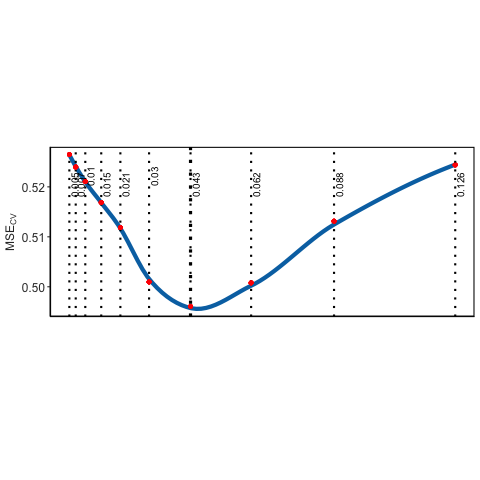

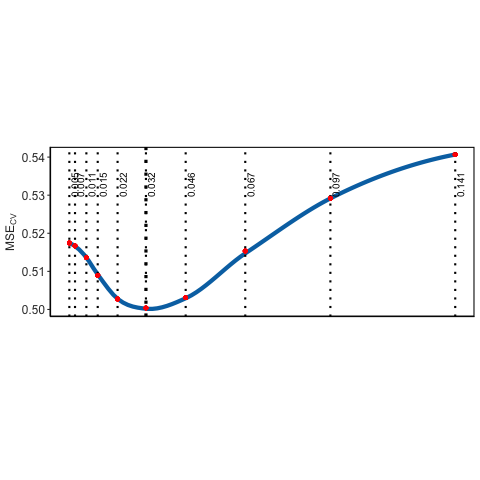

In [275]:
%%R -i RH_mse_lasso_df,LH_mse_lasso_df

print(plt_mse(RH_mse_lasso_df, show_all_alphas=TRUE))
print(plt_mse(LH_mse_lasso_df, show_all_alphas=TRUE))

In [276]:
#### Import lasso csv files for plotting ####

## Depth ##
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_all_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_all_lasso_df.csv")

### Plot LASSO Results
If there are too many alpha values in the graphs below and it makes the graphs crowded, simply change the alpha values that you feed into the LASSO models above.

In [277]:
alpha_min_RH = RH_mse_lasso_df[RH_mse_lasso_df['MSE'] == min(RH_mse_lasso_df['MSE'])]['alpha']
alpha_min_LH = LH_mse_lasso_df[LH_mse_lasso_df['MSE'] == min(LH_mse_lasso_df['MSE'])]['alpha']

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
quartz_off_screen 
                2 


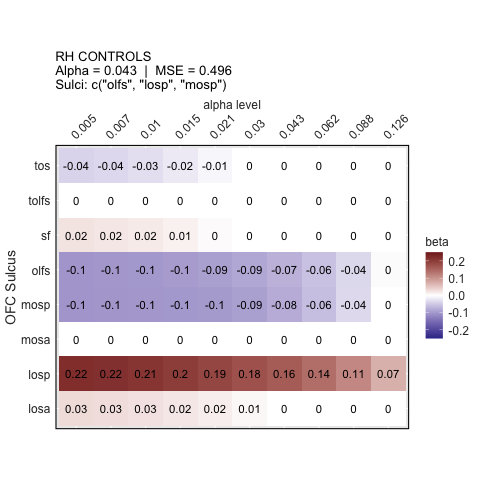

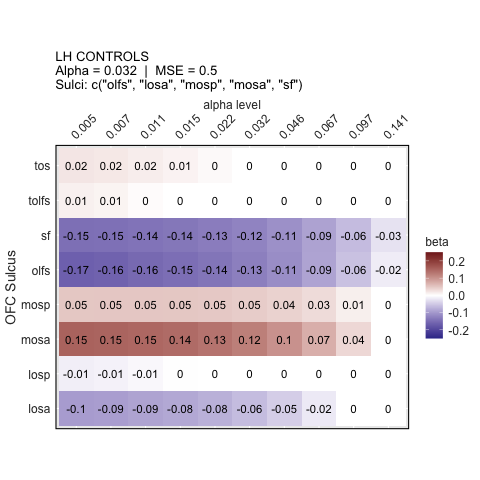

In [278]:
%%R -i RH_mse_lasso_df,RH_all_lasso_df,LH_mse_lasso_df,LH_all_lasso_df -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

# RH CONTROL
alpha_min_RH = RH_mse_lasso_df$alpha[RH_mse_lasso_df$MSE == min(RH_mse_lasso_df$MSE)]
mse_val_RH = RH_all_lasso_df$MSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "RH CONTROLS
Alpha = ", as.character(alpha_min_RH), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH CONTROL
alpha_min_LH = LH_mse_lasso_df$alpha[LH_mse_lasso_df$MSE == min(LH_mse_lasso_df$MSE)]
mse_val_LH = LH_all_lasso_df$MSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "LH CONTROLS
Alpha = ", as.character(alpha_min_LH), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))


### SAVE OUT
# RH
ragg::agg_tiff("results/OFC_RH_dpth_lasso_plt.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(RH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_RH_dpth_mse_plt.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(RH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()
# LH
ragg::agg_tiff("results/OFC_LH_dpth_lasso_plt.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(LH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_LH_dpth_mse_plt.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(LH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()

## Full Model Summary and Evaluation

In [279]:
alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_cv(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_cv(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

In [280]:
# zip up the sulcal labels with corresponding coefficient values
labels = results_dict_rh['best_grid_features']
measurements = results_dict_rh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_RH = list(zip(labels, filtered_measurements))

labels = results_dict_lh['best_grid_features']
measurements = results_dict_lh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_LH = list(zip(labels, filtered_measurements))

### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
MSE at optimal alpha:     {results_dict_rh['final_mse']}
Selected coefficients: 
{sulc_betas_RH}
      ''')

print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()

### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
MSE at optimal alpha:     {results_dict_lh['final_mse']}
Selected coefficients: 
{sulc_betas_LH}
      ''')

RH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.043]}
R^2 at optimal alpha:     0.06063078460455251
MSE at optimal alpha:     0.48737868765924175
Selected coefficients: 
[('olfs', -0.0748865924501744), ('losp', 0.16144129765333426), ('mosp', -0.08000979335416239)]
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.032]}
R^2 at optimal alpha:     0.0706755389842959
MSE at optimal alpha:     0.4895412850773515
Selected coefficients: 
[('olfs', -0.12826881885357705), ('losa', -0.06390817751067365), ('mosp', 0.04539161460594522), ('mosa', 0.12179390887348295), ('sf', -0.1231295426234139)]
      


100%|█████████████████████████████████████████████| 5000/5000 [08:39<00:00,  9.62it/s]


Original RH MSE: 0.48737868765924175
Permuted (exact) p-value: 0.0188



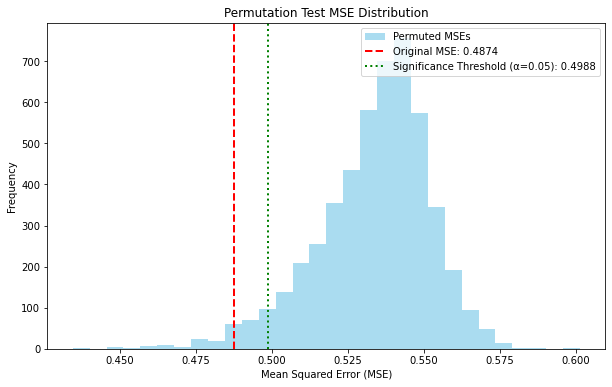

In [297]:
### RIGHT HEMISPHERE PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_RH_df[X_sulc], 
                                                            lasso_RH_df[beh_var],
                                                            alpha_dict_vf_RH,
                                                            lasso_cv, n_permutations=5000)
print("Original RH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

100%|█████████████████████████████████████████████| 5000/5000 [09:42<00:00,  8.58it/s]


Original LH MSE: 0.4895412850773515
Permuted (exact) p-value: 0.0064



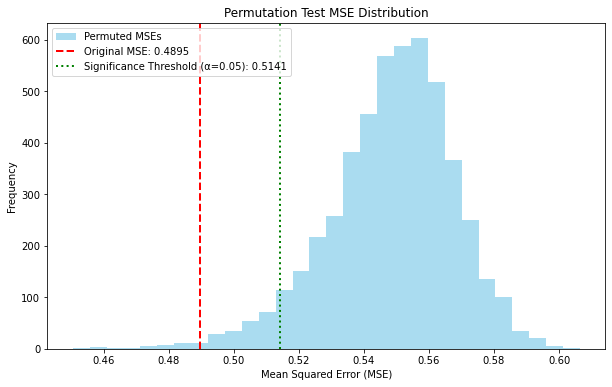

In [298]:
### LEFT HEMISPHERE PERMUTATIONS: TIME WARNING!!
# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_LH_df[X_sulc], 
                                                            lasso_LH_df[beh_var],
                                                            alpha_dict_vf_LH,
                                                            lasso_cv, n_permutations=5000)
print("Original LH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

### Spearman correlation: measured vs. predicted

In [281]:
preds_df_RH = results_dict_rh['model_preds_df'].loc[:, 'Measured':]
preds_df_LH = results_dict_lh['model_preds_df'].loc[:, 'Measured':]

corr_RH, p_val_RH = spearmanr(preds_df_RH['Measured'], preds_df_RH['Predicted'])
corr_LH, p_val_LH = spearmanr(preds_df_LH['Measured'], preds_df_LH['Predicted'])

print(corr_RH, p_val_RH)
print(corr_LH, p_val_LH)

0.26731732704666644 0.006605306519535379
0.2446678869131949 0.010345760457864311


`geom_smooth()` using formula = 'y ~ x'


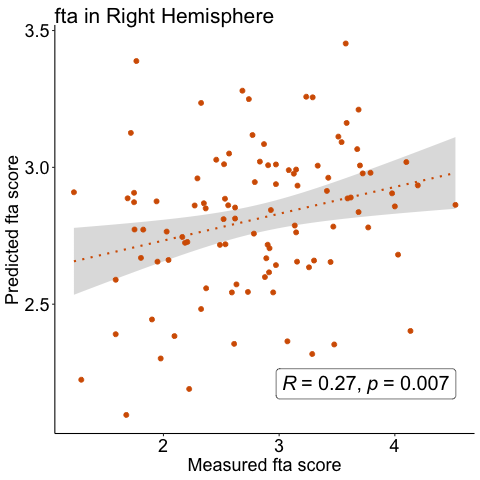

In [282]:
%%R -i preds_df_RH,beh_var
### RIGHT HEMISPHERE
scatter = ggplot(preds_df_RH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Right Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

`geom_smooth()` using formula = 'y ~ x'


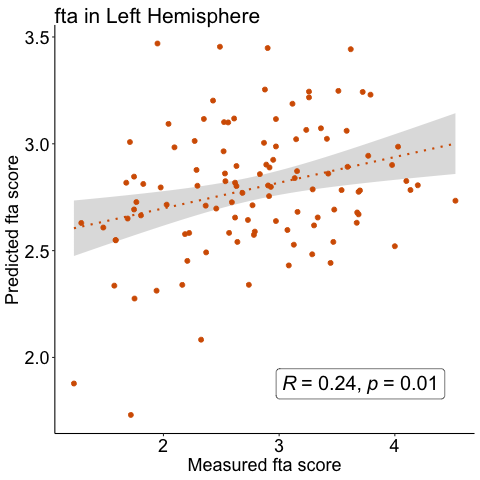

In [283]:
%%R -i preds_df_LH,beh_var
### LEFT HEMISPHERE
scatter = ggplot(preds_df_LH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Left Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

In [284]:
# Assuming preds_df_RH and preds_df_LH are your dataframes for right and left hemispheres respectively
original_corr_RH, p_value_RH, shuffled_cors_RH = permutation_test_spearman(preds_df_RH, n_permutations=5000)
original_corr_LH, p_value_LH, shuffled_cors_LH = permutation_test_spearman(preds_df_LH, n_permutations=5000)
# Output results
print(f"Right Hemisphere: Original Spearman Correlation: {original_corr_RH}, Permuted p-value: {p_value_RH}")
print(f"Left Hemisphere:  Original Spearman Correlation: {original_corr_LH}, Permuted p-value: {p_value_LH}")

100%|███████████████████████████████████████████| 5000/5000 [00:01<00:00, 3073.62it/s]

Right Hemisphere: Original Spearman Correlation: 0.26731732704666644, Permuted p-value: 0.0022
Left Hemisphere:  Original Spearman Correlation: 0.2446678869131949, Permuted p-value: 0.005


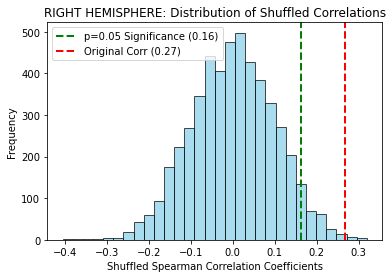

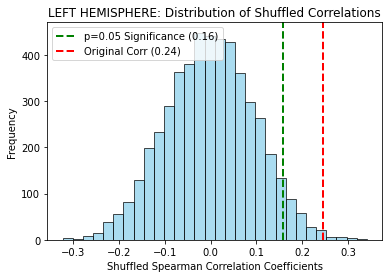

In [285]:
# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_RH = np.sort(shuffled_cors_RH)
threshold_index = int(len(sorted_shuffled_cors_RH) * 0.95)
significance_threshold = sorted_shuffled_cors_RH[threshold_index]

# Create histogram
plt.hist(shuffled_cors_RH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_RH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_RH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('RIGHT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_LH = np.sort(shuffled_cors_LH)
threshold_index = int(len(sorted_shuffled_cors_LH) * 0.95)
significance_threshold = sorted_shuffled_cors_LH[threshold_index]

# Create histogram
plt.hist(sorted_shuffled_cors_LH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_LH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_LH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('LEFT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

### Further model comparison

AIC is a relative measure. In order to assess the fit we will compare the AIC value of each alternative model to our best model. THe model with the lowest AIC is better. To report a difference the difference in AIC must be > 2. A difference > 10 is considered substantial. 

### AIC Comparison
First we calculate AIC scores from each of our models. Remember that with AIC, LOWER is better.

In [286]:
##### Make thickness dataframe for AIC comparison

### Paths to sulc_morphology CSV and behavioral CSV
# sulc_df_path = working_dir + "/data/tertiary_depth_lasso.csv"
sulc_df_path_thck = working_dir + "/data/tertiary_ct_lasso.csv"
# morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'
morph_df_import_thck = pd.read_csv(sulc_df_path_thck)
morph_df_thck = morph_df_import_thck.sort_values(by = "sub").reset_index(drop=True)
morph_df_thck = morph_df_thck.loc[:, ~morph_df_thck.columns.isin(["Unnamed: 0"])]
morph_df_thck.head()

## Data Processing
sulc_list = ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']
# Create dataframes for analysis
subset_fta_df_thck = morph_df_thck[['sub', 'hemi', 'fta'] + sulc_list].dropna()
fta_RH_df_thck = subset_fta_df_thck[(subset_fta_df_thck['hemi'] == 'rh')] 
fta_LH_df_thck = subset_fta_df_thck[(subset_fta_df_thck['hemi'] == 'lh')]

# Down-select to only the sulci that were selected by depth LASSO
rh_fta_depth_sulc = ['olfs', 'losp', 'mosp']
lh_fta_depth_sulc = ['olfs', 'losa', 'mosp', 'mosa', 'sf']
fta_RH_df_thck = fta_RH_df_thck[['sub', 'hemi', 'fta'] + rh_fta_depth_sulc]
fta_LH_df_thck = fta_LH_df_thck[['sub', 'hemi', 'fta'] + lh_fta_depth_sulc]
print(fta_RH_df_thck.head())
print(fta_LH_df_thck.head())

   sub hemi       fta   olfs   losp   mosp
1  103   rh  2.738095  2.476  2.204  3.017
3  111   rh  2.186508  2.283  2.406  2.801
4  115   rh  2.900794  2.205  3.117  3.055
6  118   rh  3.698413  1.985  2.491  2.960
7  123   rh  2.591270  2.243  2.758  2.985
    sub hemi       fta   olfs   losa   mosp   mosa     sf
0   103   lh  2.738095  2.439  2.230  2.704  2.681  2.928
2   111   lh  2.186508  2.314  2.402  2.882  3.590  2.614
5   115   lh  2.900794  2.258  2.586  3.498  2.840  3.500
8   123   lh  2.591270  2.146  2.935  2.849  2.707  3.067
10  124   lh  3.769841  2.305  2.830  2.803  2.463  3.024


In [287]:
# run FTA lasso regressions again to make sure we're dealing with FTA LASSO and not something else
results_dict_rh = lasso_cv(lasso_RH_df[X_sulc], lasso_RH_df['fta'], {'alpha': [.044]})
results_dict_lh = lasso_cv(lasso_LH_df[X_sulc], lasso_LH_df['fta'], {'alpha': [.029]})

# FTA linear regressions with all OFC sulci included as predictors
results_dict_rh_full_fta = linreg_cv(fta_RH_df[sulc_list], fta_RH_df[['fta']])
results_dict_lh_full_fta = linreg_cv(fta_LH_df[sulc_list], fta_LH_df[['fta']])

# PIF linear regressions (with same sulci as were selected by depth FTA LASSO)
results_dict_rh_pif = linreg_cv(pif_RH_df[rh_fta_depth_sulc], pif_RH_df['pif'])
results_dict_lh_pif = linreg_cv(pif_LH_df[lh_fta_depth_sulc], pif_LH_df['pif'])

# LFT linear regressions (with same sulci as were selected by depth FTA LASSO)
results_dict_rh_lft = linreg_cv(lft_RH_df[rh_fta_depth_sulc], lft_RH_df[['lft']])
results_dict_lh_lft = linreg_cv(lft_LH_df[lh_fta_depth_sulc], lft_LH_df[['lft']])

# FTA regressions with cortical thickness (but same predictors as for depth)
results_dict_rh_fta_thck = linreg_cv(fta_RH_df_thck[rh_fta_depth_sulc], fta_RH_df_thck[['fta']])
results_dict_lh_fta_thck = linreg_cv(fta_LH_df_thck[lh_fta_depth_sulc], fta_LH_df_thck[['fta']])

In [288]:
### get MSE for each model

## FTA depth models
rh_lasso_mse = results_dict_rh['final_mse']
rh_all_mse = results_dict_rh_full_fta['mse']
lh_lasso_mse = results_dict_lh['final_mse']
lh_all_mse = results_dict_lh_full_fta['mse']

## PIF depth models
rh_mse_pif = results_dict_rh_pif['mse']
lh_mse_pif = results_dict_lh_pif['mse']

## LFT depth models
rh_mse_lft = results_dict_rh_lft['mse']
lh_mse_lft = results_dict_lh_lft['mse']

## FTA thickness models
rh_fta_thck_mse = results_dict_rh_fta_thck['mse']
lh_fta_thck_mse = results_dict_lh_fta_thck['mse']

print("RH LASSO MSE = {}".format(rh_lasso_mse))
print("RH ALL   MSE = {}".format(rh_all_mse))
print("LH LASSO MSE = {}".format(lh_lasso_mse))
print("LH ALL   MSE = {}".format(lh_all_mse))
print()
print("RH MSE for PIF = {}".format(rh_mse_pif))
print("LH MSE for PIF = {}".format(lh_mse_pif))
print()
print("RH MSE for LFT = {}".format(rh_mse_lft))
print("LH MSE for LFT = {}".format(lh_mse_lft))
print()
print("RH THCK MSE = {}".format(rh_fta_thck_mse))
print("LH THCK MSE = {}".format(lh_fta_thck_mse))

RH LASSO MSE = 0.48737868765924175
RH ALL   MSE = 0.535166366195236
LH LASSO MSE = 0.4895412850773515
LH ALL   MSE = 0.5182913292787956

RH MSE for PIF = 0.5718275640956189
LH MSE for PIF = 0.6306071920394746

RH MSE for LFT = 0.6389161527891668
LH MSE for LFT = 0.6386605561454792

RH THCK MSE = 0.5205929456983994
LH THCK MSE = 0.5679366861076107


In [289]:
## AIC from RH Lasso model ##
# n = sample size (this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression))
# number of params = (# of sulci) + intercept
n = 102  # this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression)
num_params = len(results_dict_rh['best_grid_features']) + 1
AIC_rh_lasso = calculate_aic(n, rh_lasso_mse, num_params)
print(AIC_rh_lasso)

## AIC from RH ALL model ##
# n = sample size of hemispheres, number of params = (# of sulci) + intercept
n = 102
num_params = len(sulc_list) + 1  # number of sulci in the ALL model, plus intercept
AIC_rh_all = calculate_aic(n, rh_all_mse, num_params)
print(AIC_rh_all)

print()

## AIC from LH Lasso model ##
n = 109
num_params = len(results_dict_lh['best_grid_features']) + 1
AIC_lh_lasso = calculate_aic(n, lh_lasso_mse, num_params)
print(AIC_lh_lasso)

## AIC from lh ALL model ##
n = 109
num_params = len(sulc_list) + 1
AIC_lh_all = calculate_aic(n, lh_all_mse, num_params)
print(AIC_lh_all)

print()

## AIC from RH LFT model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_lft = calculate_aic(n, rh_mse_lft, num_params)
print(AIC_rh_lft)

## AIC from LH LFT model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_lft = calculate_aic(n, lh_mse_lft, num_params)
print(AIC_lh_lft)

print()

## AIC from RH PIF model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_pif = calculate_aic(n, rh_mse_pif, num_params)
print(AIC_rh_pif)

## AIC from LH PIF model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_pif = calculate_aic(n, lh_mse_pif, num_params)
print(AIC_lh_pif)

print()

## AIC from RH FTA thickness model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_thck = calculate_aic(n, rh_fta_thck_mse, num_params)
print(AIC_rh_thck)

## AIC from LH FTA thickness model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_thck = calculate_aic(n, lh_fta_thck_mse, num_params)
print(AIC_lh_thck)

-65.30881426454658
-45.768116788626564

-65.85722623777328
-53.636738355909

-37.69416904967287
-36.873657269795196

-49.00961503106933
-38.25686182801413

-58.58425735799614
-49.666241470791995


###### Note that a negative delta AIC simply indicates that you need to flip the subtraction around (i.e. the model you thought was better is actually worse.)

In [290]:
# lower AIC is better. AIC delta>2 is an interpretable difference. delta>10 is substantial

print("RH Models: ALL - LASSO")
delta_AIC_rh = AIC_rh_all - AIC_rh_lasso
print('''
RH_ALL AIC         = {}
RH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_rh_all, AIC_rh_lasso, delta_AIC_rh))

print()

print("LH Models: ALL - LASSO")
delta_AIC_lh = AIC_lh_all - AIC_lh_lasso
print('''
LH_ALL AIC         = {}
LH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_lh_all, AIC_lh_lasso, delta_AIC_lh))

print()
print('#########################################################')
print()

print("RH Models: Thickness - Depth")
delta_AIC_rh_morph = AIC_rh_thck - AIC_rh_lasso
print('''
RH_Depth AIC         = {}
RH_Thick AIC         = {}
Delta                    = {}
'''.format(AIC_rh_lasso, AIC_rh_thck, delta_AIC_rh_morph))

print()

print("LH Models: Thickness - Depth")
delta_AIC_lh_morph = AIC_lh_thck - AIC_lh_lasso
print('''
LH_Depth AIC         = {}
LH_Thick AIC         = {}
Delta                    = {}
'''.format(AIC_lh_lasso, AIC_lh_thck, delta_AIC_lh_morph))

print()
print('#########################################################')
print()

print("RH Models: LFT - FTA")
delta_AIC_rh_lft = AIC_rh_lft - AIC_rh_lasso
print('''
RH_LFT AIC         = {}
RH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_rh_lft, AIC_rh_lasso, delta_AIC_rh_lft))

print()

print("LH Models: LFT - FTA")
delta_AIC_lh_lft = AIC_lh_lft - AIC_lh_lasso
print('''
LH_LFT AIC         = {}
LH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_lh_lft, AIC_lh_lasso, delta_AIC_lh_lft))

print()
print('#########################################################')
print()

print("RH Models: PIF - FTA")
delta_AIC_rh_pif = AIC_rh_pif - AIC_rh_lasso
print('''
RH_PIF AIC         = {}
RH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_rh_pif, AIC_rh_lasso, delta_AIC_rh_pif))

print()

print("LH Models: PIF - FTA")
delta_AIC_lh_pif = AIC_lh_pif - AIC_lh_lasso
print('''
LH_PIF AIC         = {}
LH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_lh_pif, AIC_lh_lasso, delta_AIC_lh_pif))

print()
print('#########################################################')
print()

print("Hemisphere Comparison Example: LH - RH")
delta_AIC_hemi = AIC_lh_lasso - AIC_rh_lasso
print('''
LH_LASSO AIC       = {}
RH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_lh_lasso, AIC_rh_lasso, delta_AIC_hemi))

RH Models: ALL - LASSO

RH_ALL AIC         = -45.768116788626564
RH_LASSO AIC       = -65.30881426454658
Delta                    = 19.54069747592002


LH Models: ALL - LASSO

LH_ALL AIC         = -53.636738355909
LH_LASSO AIC       = -65.85722623777328
Delta                    = 12.220487881864273


#########################################################

RH Models: Thickness - Depth

RH_Depth AIC         = -65.30881426454658
RH_Thick AIC         = -58.58425735799614
Delta                    = 6.724556906550447


LH Models: Thickness - Depth

LH_Depth AIC         = -65.85722623777328
LH_Thick AIC         = -49.666241470791995
Delta                    = 16.19098476698128


#########################################################

RH Models: LFT - FTA

RH_LFT AIC         = -37.69416904967287
RH_FTA AIC         = -65.30881426454658
Delta                    = 27.61464521487371


LH Models: LFT - FTA

LH_LFT AIC         = -36.873657269795196
LH_FTA AIC         = -65.85722623777328
Delta

# LASSO (fully nested)

In [291]:
#### RUN LASSO and get all beta coefficients ####

### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]
# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis_fully_nested(file_label = label,
                        sulc_df = data,
                        X_inds = X_sulc,
                        y_dep = beh_var,
                        alphas = alphas,
                        model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 102

Alpha values: {'alpha': [0.005, 0.007, 0.01, 0.015, 0.021, 0.03, 0.043, 0.062, 0.088, 0.126]}

Predictors: ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']

depth_RH_fta
Here's the data you're working with:


,sub,hemi,fta,olfs,losa,losp,mosp,tolfs,tos,mosa,sf
1,103,rh,2.738095,-0.039086,-0.158906,0.106147,0.083681,0.111416,0.284077,0.019753,-0.050473
3,111,rh,2.186508,0.020358,-0.104421,0.031968,0.171853,0.071470,0.346033,0.159984,0.045069
5,115,rh,2.900794,0.022688,-0.064511,0.012098,0.135569,0.101668,0.305173,0.021485,0.005142
6,118,rh,3.698413,-0.051737,-0.046666,0.042301,0.116709,0.024840,0.339726,0.006506,0.100437
8,123,rh,2.591270,0.011671,-0.117570,-0.084043,0.102047,0.036696,0.295196,0.109633,0.014964



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 109

Alpha values: {'alpha': [0.005, 0.007, 0.011, 0.015, 0.022, 0.032, 0.046, 0.067, 0.097, 0.141]}

Predictors: ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']

depth_LH_fta
Here's the data you're working with:


,sub,hemi,fta,olfs,losa,losp,mosp,tolfs,tos,mosa,sf
0,103,lh,2.738095,0.014585,0.092684,-0.040952,0.043437,0.049617,0.277640,0.027705,-0.043463
2,111,lh,2.186508,-0.011198,-0.036932,-0.045451,0.052756,-0.050310,0.248951,0.039208,-0.033671
4,115,lh,2.900794,-0.083331,-0.145578,0.062939,0.181577,0.059676,0.386163,0.098441,-0.132194
7,123,lh,2.591270,-0.056577,0.191174,-0.050951,0.119041,-0.060079,0.306877,0.145612,-0.004287
10,124,lh,3.769841,-0.086155,0.118434,-0.033378,0.193081,-0.119384,0.308629,0.090860,-0.055626



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [292]:
#### Import lasso csv files for plotting and calculate median betas and MSE's from all folds ####
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_mse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_mse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df.csv")

# Calculate median values for beta coefficients and MSE
median_betas_RH = RH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_MSE_RH = RH_all_lasso_df.groupby('alpha_level')['MSE'].median().reset_index()
median_betas_LH = LH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_MSE_LH = LH_all_lasso_df.groupby('alpha_level')['MSE'].median().reset_index()
# Merge the two 'all' dataframes on 'alpha_level'
RH_all_lasso_df = pd.merge(median_betas_RH, median_MSE_RH, on='alpha_level', how='left')
LH_all_lasso_df = pd.merge(median_betas_LH, median_MSE_LH, on='alpha_level', how='left')
# Group mse df by alpha value
RH_mse_lasso_df = RH_mse_lasso_df.groupby('alpha')['MSE'].median().reset_index()
LH_mse_lasso_df = LH_mse_lasso_df.groupby('alpha')['MSE'].median().reset_index()

RH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_all_lasso_df_median.csv'), index=False)
LH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_all_lasso_df_median.csv'), index=False)
RH_mse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_mse_lasso_df_median.csv'), index=False)
LH_mse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_mse_lasso_df_median.csv'), index=False)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


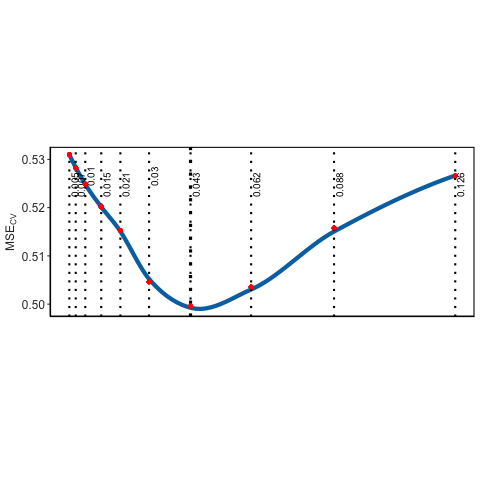

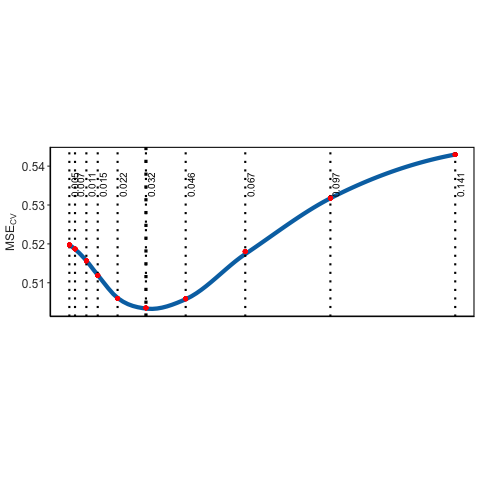

In [293]:
%%R -i RH_mse_lasso_df,LH_mse_lasso_df
print(plt_mse(RH_mse_lasso_df, show_all_alphas=TRUE))
print(plt_mse(LH_mse_lasso_df, show_all_alphas=TRUE))

In [294]:
#### Import lasso csv files for plotting ####
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_mse_lasso_df_median.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df_median.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_mse_lasso_df_median.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df_median.csv")

### Plot LASSO Results
If there are too many alpha values in the graphs below and it makes the graphs crowded, simply change the alpha values that you feed into the LASSO models above.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
quartz_off_screen 
                2 


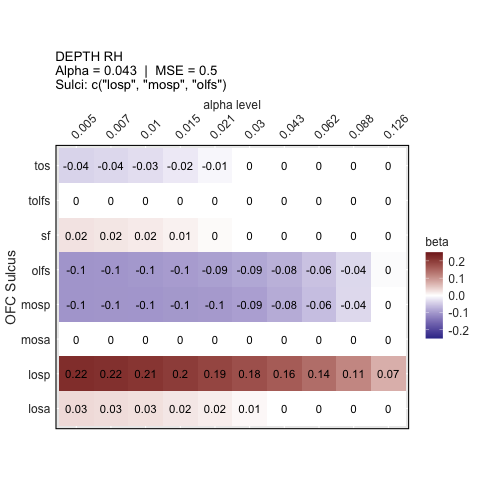

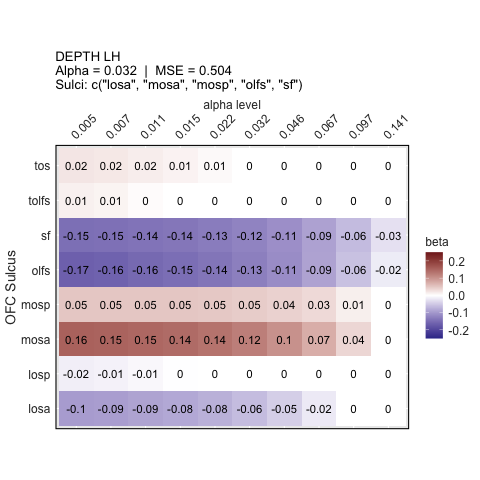

In [295]:
%%R -i RH_mse_lasso_df,RH_all_lasso_df,LH_mse_lasso_df,LH_all_lasso_df -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

# RH CONTROL
alpha_min_RH = RH_mse_lasso_df$alpha[RH_mse_lasso_df$MSE == min(RH_mse_lasso_df$MSE)]
mse_val_RH = RH_all_lasso_df$MSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH RH
Alpha = ", as.character(alpha_min_RH), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH CONTROL
alpha_min_LH = LH_mse_lasso_df$alpha[LH_mse_lasso_df$MSE == min(LH_mse_lasso_df$MSE)]
mse_val_LH = LH_all_lasso_df$MSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH LH
Alpha = ", as.character(alpha_min_LH), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))

### SAVE OUT
# RH
ragg::agg_tiff("results/OFC_RH_dpth_lasso_plt_NESTED.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(RH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_RH_dpth_mse_plt_NESTED.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(RH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()
# LH
ragg::agg_tiff("results/OFC_LH_dpth_lasso_plt_NESTED.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(LH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_LH_dpth_mse_plt_NESTED.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(LH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()

## Full Model Summary and Evaluation

In [296]:
alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

Sulcus Statistics for RH:
  Sulcus  Count  Percentage Hemisphere
0   olfs    102  100.000000         RH
1   losp    102  100.000000         RH
2   mosp    102  100.000000         RH
3   losa     11   10.784314         RH
4    tos      1    0.980392         RH
5     sf      1    0.980392         RH

Sulcus Statistics for LH:
  Sulcus  Count  Percentage Hemisphere
0   olfs    109  100.000000         LH
1   losa    109  100.000000         LH
2   mosp    109  100.000000         LH
3   mosa    109  100.000000         LH
4     sf    109  100.000000         LH
5    tos     29   26.605505         LH
6   losp      1    0.917431         LH



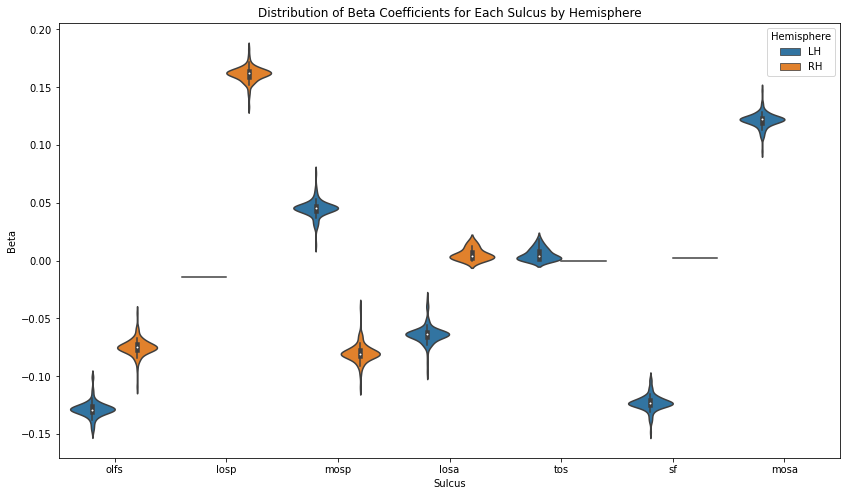

Medians for each Sulcus in the Right Hemisphere:
olfs   -0.08
losp    0.16
mosp   -0.08
dtype: float64

Medians for each Sulcus in the Left Hemisphere:
olfs   -0.13
losa   -0.06
mosp    0.05
mosa    0.12
sf     -0.12
dtype: float64


In [297]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have data for both hemispheres
df_RH = pd.DataFrame(results_dict_rh['sulc_beta_dicts'])
df_LH = pd.DataFrame(results_dict_lh['sulc_beta_dicts'])

# Add Hemisphere column to differentiate the data
df_RH['Hemisphere'] = 'RH'
df_LH['Hemisphere'] = 'LH'
df_combined = pd.concat([df_RH, df_LH], ignore_index=True)

# Calculate counts and percentages separately for each hemisphere
sulcus_counts_RH = df_RH.drop(columns='Hemisphere').count()
sulcus_counts_LH = df_LH.drop(columns='Hemisphere').count()
total_dicts_RH = len(df_RH)
total_dicts_LH = len(df_LH)
sulcus_percentage_RH = (sulcus_counts_RH / total_dicts_RH) * 100
sulcus_percentage_LH = (sulcus_counts_LH / total_dicts_LH) * 100

# Create DataFrames for each hemisphere's statistics
sulcus_stats_RH = pd.DataFrame({
    'Sulcus': sulcus_counts_RH.index,
    'Count': sulcus_counts_RH.values,
    'Percentage': sulcus_percentage_RH.values,
    'Hemisphere': 'RH'
})
sulcus_stats_LH = pd.DataFrame({
    'Sulcus': sulcus_counts_LH.index,
    'Count': sulcus_counts_LH.values,
    'Percentage': sulcus_percentage_LH.values,
    'Hemisphere': 'LH'
})

print("Sulcus Statistics for RH:")
print(sulcus_stats_RH)
print()
print("Sulcus Statistics for LH:")
print(sulcus_stats_LH)
print()

# Melt the combined DataFrame for easier plotting
df_melted = df_combined.melt(id_vars='Hemisphere', var_name='Sulcus', value_name='Beta')

# Plotting
plt.figure(figsize=(14, 8))
sns.violinplot(x='Sulcus', y='Beta', hue='Hemisphere', data=df_melted, hue_order=['LH', 'RH'])
plt.title('Distribution of Beta Coefficients for Each Sulcus by Hemisphere')
plt.show()

# Calculate and print medians for each hemisphere separately (ONLY FOR SULCI SELECTED >50% OF THE TIME)
df_RH_numeric = df_RH.select_dtypes(include=[np.number])
df_LH_numeric = df_LH.select_dtypes(include=[np.number])
medians_RH = df_RH_numeric.loc[:, df_RH_numeric.count() > total_dicts_RH / 2].median().round(2)
medians_LH = df_LH_numeric.loc[:, df_LH_numeric.count() > total_dicts_LH / 2].median().round(2)
print("Medians for each Sulcus in the Right Hemisphere:")
print(medians_RH)
print()
print("Medians for each Sulcus in the Left Hemisphere:")
print(medians_LH)


In [298]:
# Print all results

### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
MSE at optimal alpha:     {results_dict_rh['final_mse']}
Selected coefficients (median): 
{medians_RH}
      ''')
print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()
### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
MSE at optimal alpha:     {results_dict_lh['final_mse']}
Selected coefficients (median): 
{medians_LH}
      ''')

RH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.043]}
R^2 at optimal alpha:     0.044121773004542786
MSE at optimal alpha:     0.4959441593356547
Selected coefficients (median): 
olfs   -0.08
losp    0.16
mosp   -0.08
dtype: float64
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.032]}
R^2 at optimal alpha:     0.049961127726822485
MSE at optimal alpha:     0.500453038648888
Selected coefficients (median): 
olfs   -0.13
losa   -0.06
mosp    0.05
mosa    0.12
sf     -0.12
dtype: float64
      


100%|███████████████████████████████████████████| 5000/5000 [4:35:29<00:00,  3.31s/it]


Original RH MSE: 0.4959441593356547
Permuted (exact) p-value: 0.0162



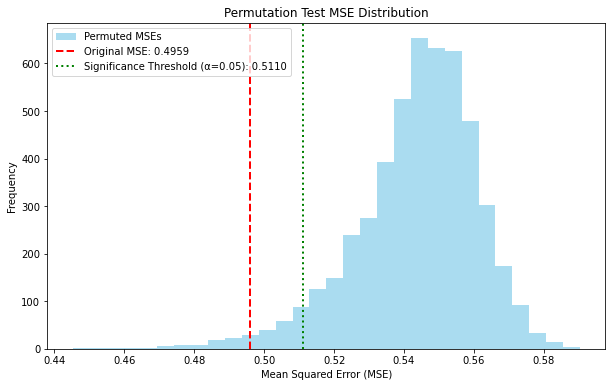

In [317]:
### RIGHT HEMISPHERE PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_RH_df[X_sulc], 
                                                            lasso_RH_df[beh_var],
                                                            alpha_dict_vf_RH,
                                                            lasso_fully_nested, n_permutations=5000)

print("Original RH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

100%|███████████████████████████████████████████| 5000/5000 [5:15:05<00:00,  3.78s/it]


Original LH MSE: 0.500453038648888
Permuted (exact) p-value: 0.009



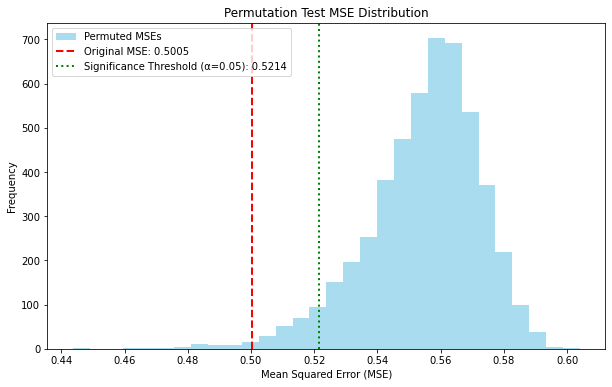

In [54]:
### LEFT HEMISPHERE PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_LH_df[X_sulc], 
                                                            lasso_LH_df[beh_var],
                                                            alpha_dict_vf_LH,
                                                            lasso_fully_nested, n_permutations=5000)

print("Original LH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

### Spearman correlation: measured vs. predicted

In [299]:
preds_df_RH = results_dict_rh['final_model_preds_df'].loc[:, 'Measured':]
preds_df_LH = results_dict_lh['final_model_preds_df'].loc[:, 'Measured':]

corr_RH, p_val_RH = spearmanr(preds_df_RH['Measured'], preds_df_RH['Predicted'])
corr_LH, p_val_LH = spearmanr(preds_df_LH['Measured'], preds_df_LH['Predicted'])

print(corr_RH, p_val_RH)
print(corr_LH, p_val_LH)

0.22076269757644595 0.02576728040890175
0.19375854324871994 0.04351315425085653


`geom_smooth()` using formula = 'y ~ x'


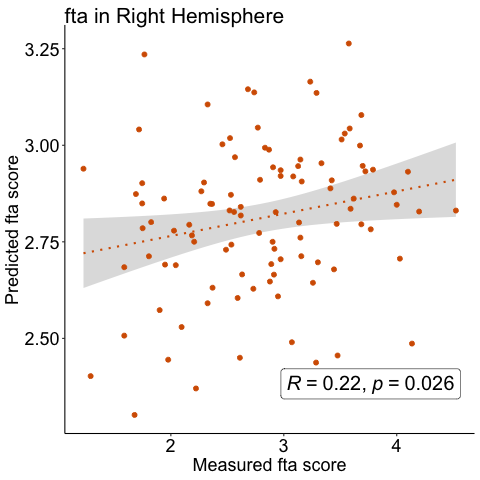

In [300]:
%%R -i preds_df_RH,beh_var
### RIGHT HEMISPHERE
scatter = ggplot(preds_df_RH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Right Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

`geom_smooth()` using formula = 'y ~ x'


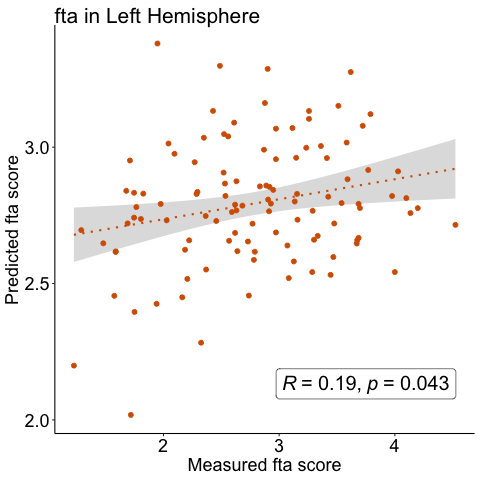

In [301]:
%%R -i preds_df_LH,beh_var
### LEFT HEMISPHERE
scatter = ggplot(preds_df_LH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Left Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

In [302]:
# Assuming preds_df_RH and preds_df_LH are your dataframes for right and left hemispheres respectively
original_corr_RH, p_value_RH, shuffled_cors_RH = permutation_test_spearman(preds_df_RH, n_permutations=5000)
original_corr_LH, p_value_LH, shuffled_cors_LH = permutation_test_spearman(preds_df_LH, n_permutations=5000)
# Output results
print(f"Right Hemisphere: Original Spearman Correlation: {original_corr_RH}, Permuted p-value: {p_value_RH}")
print(f"Left Hemisphere:  Original Spearman Correlation: {original_corr_LH}, Permuted p-value: {p_value_LH}")

100%|███████████████████████████████████████████| 5000/5000 [00:01<00:00, 3072.15it/s]

Right Hemisphere: Original Spearman Correlation: 0.22076269757644595, Permuted p-value: 0.0118
Left Hemisphere:  Original Spearman Correlation: 0.19375854324871994, Permuted p-value: 0.0194


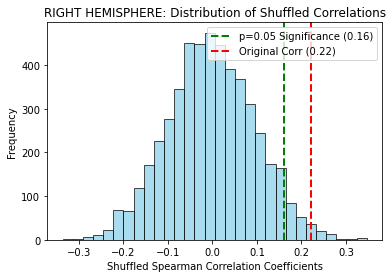

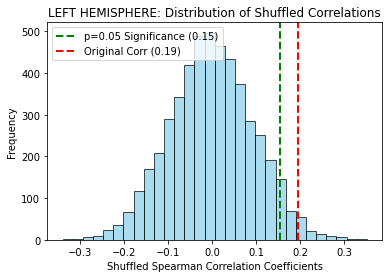

In [303]:
# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_RH = np.sort(shuffled_cors_RH)
threshold_index = int(len(sorted_shuffled_cors_RH) * 0.95)
significance_threshold = sorted_shuffled_cors_RH[threshold_index]
# Create histogram
plt.hist(shuffled_cors_RH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_RH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_RH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('RIGHT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_LH = np.sort(shuffled_cors_LH)
threshold_index = int(len(sorted_shuffled_cors_LH) * 0.95)
significance_threshold = sorted_shuffled_cors_LH[threshold_index]
# Create histogram
plt.hist(sorted_shuffled_cors_LH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_LH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_LH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('LEFT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

### AIC Comparison
First we calculate AIC scores from each of our models. Remember that with AIC, LOWER is better.

In [304]:
##### Make thickness dataframe for AIC comparison

### Paths to sulc_morphology CSV and behavioral CSV
# sulc_df_path = working_dir + "/data/tertiary_depth_lasso.csv"
sulc_df_path_thck = working_dir + "/data/tertiary_ct_lasso.csv"
# morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'
morph_df_import_thck = pd.read_csv(sulc_df_path_thck)
morph_df_thck = morph_df_import_thck.sort_values(by = "sub").reset_index(drop=True)
morph_df_thck = morph_df_thck.loc[:, ~morph_df_thck.columns.isin(["Unnamed: 0"])]
morph_df_thck.head()

## Data Processing
sulc_list = ['olfs', 'losa', 'losp', 'mosp', 'tolfs', 'tos', 'mosa', 'sf']
# Create dataframes for analysis
subset_fta_df_thck = morph_df_thck[['sub', 'hemi', 'fta'] + sulc_list].dropna()
fta_RH_df_thck = subset_fta_df_thck[(subset_fta_df_thck['hemi'] == 'rh')] 
fta_LH_df_thck = subset_fta_df_thck[(subset_fta_df_thck['hemi'] == 'lh')]

# Down-select to only the sulci that were selected by depth LASSO
rh_fta_depth_sulc = ['olfs', 'losp', 'mosp']
lh_fta_depth_sulc = ['olfs', 'losa', 'mosp', 'mosa', 'sf', 'tos']
fta_RH_df_thck = fta_RH_df_thck[['sub', 'hemi', 'fta'] + rh_fta_depth_sulc]
fta_LH_df_thck = fta_LH_df_thck[['sub', 'hemi', 'fta'] + lh_fta_depth_sulc]
print(fta_RH_df_thck.head())
print(fta_LH_df_thck.head())

   sub hemi       fta   olfs   losp   mosp
1  103   rh  2.738095  2.476  2.204  3.017
3  111   rh  2.186508  2.283  2.406  2.801
4  115   rh  2.900794  2.205  3.117  3.055
6  118   rh  3.698413  1.985  2.491  2.960
7  123   rh  2.591270  2.243  2.758  2.985
    sub hemi       fta   olfs   losa   mosp   mosa     sf    tos
0   103   lh  2.738095  2.439  2.230  2.704  2.681  2.928  2.221
2   111   lh  2.186508  2.314  2.402  2.882  3.590  2.614  2.581
5   115   lh  2.900794  2.258  2.586  3.498  2.840  3.500  2.367
8   123   lh  2.591270  2.146  2.935  2.849  2.707  3.067  2.317
10  124   lh  3.769841  2.305  2.830  2.803  2.463  3.024  2.365


In [305]:
# run FTA lasso regressions again to make sure we're dealing with FTA LASSO and not something else
results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df['fta'], {'alpha': [.044]})
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df['fta'], {'alpha': [.029]})

# FTA linear regressions with all OFC sulci included as predictors
results_dict_rh_full_fta = linreg_cv(fta_RH_df[sulc_list], fta_RH_df[['fta']])
results_dict_lh_full_fta = linreg_cv(fta_LH_df[sulc_list], fta_LH_df[['fta']])

# PIF linear regressions (with same sulci as were selected by depth FTA LASSO)
results_dict_rh_pif = linreg_cv(pif_RH_df[rh_fta_depth_sulc], pif_RH_df['pif'])
results_dict_lh_pif = linreg_cv(pif_LH_df[lh_fta_depth_sulc], pif_LH_df['pif'])

# LFT linear regressions (with same sulci as were selected by depth FTA LASSO)
results_dict_rh_lft = linreg_cv(lft_RH_df[rh_fta_depth_sulc], lft_RH_df[['lft']])
results_dict_lh_lft = linreg_cv(lft_LH_df[lh_fta_depth_sulc], lft_LH_df[['lft']])

# FTA regressions with cortical thickness (but same predictors as for depth)
results_dict_rh_fta_thck = linreg_cv(fta_RH_df_thck[rh_fta_depth_sulc], fta_RH_df_thck[['fta']])
results_dict_lh_fta_thck = linreg_cv(fta_LH_df_thck[lh_fta_depth_sulc], fta_LH_df_thck[['fta']])

In [306]:
### get MSE for each model

## FTA depth models
rh_lasso_mse = results_dict_rh['final_mse']
rh_all_mse = results_dict_rh_full_fta['mse']
lh_lasso_mse = results_dict_lh['final_mse']
lh_all_mse = results_dict_lh_full_fta['mse']

## PIF depth models
rh_mse_pif = results_dict_rh_pif['mse']
lh_mse_pif = results_dict_lh_pif['mse']

## LFT depth models
rh_mse_lft = results_dict_rh_lft['mse']
lh_mse_lft = results_dict_lh_lft['mse']

## FTA thickness models
rh_fta_thck_mse = results_dict_rh_fta_thck['mse']
lh_fta_thck_mse = results_dict_lh_fta_thck['mse']

print("RH LASSO MSE = {}".format(rh_lasso_mse))
print("RH ALL   MSE = {}".format(rh_all_mse))
print("LH LASSO MSE = {}".format(lh_lasso_mse))
print("LH ALL   MSE = {}".format(lh_all_mse))
print()
print("RH MSE for PIF = {}".format(rh_mse_pif))
print("LH MSE for PIF = {}".format(lh_mse_pif))
print()
print("RH MSE for LFT = {}".format(rh_mse_lft))
print("LH MSE for LFT = {}".format(lh_mse_lft))
print()
print("RH THCK MSE = {}".format(rh_fta_thck_mse))
print("LH THCK MSE = {}".format(lh_fta_thck_mse))

RH LASSO MSE = 0.4959359753684617
RH ALL   MSE = 0.535166366195236
LH LASSO MSE = 0.5005962045123945
LH ALL   MSE = 0.5182913292787956

RH MSE for PIF = 0.5718275640956189
LH MSE for PIF = 0.6329152338395329

RH MSE for LFT = 0.6389161527891668
LH MSE for LFT = 0.6494564578438617

RH THCK MSE = 0.5205929456983994
LH THCK MSE = 0.5778036636726641


In [307]:
## AIC from RH Lasso model ##
# n = sample size (this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression))
# number of params = (# of sulci) + intercept
n = 102  # this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression)
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_lasso = calculate_aic(n, rh_lasso_mse, num_params)
print(AIC_rh_lasso)

## AIC from RH ALL model ##
# n = sample size of hemispheres, number of params = (# of sulci) + intercept
n = 102
num_params = len(sulc_list) + 1  # number of sulci in the ALL model, plus intercept
AIC_rh_all = calculate_aic(n, rh_all_mse, num_params)
print(AIC_rh_all)

print()

## AIC from LH Lasso model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1
AIC_lh_lasso = calculate_aic(n, lh_lasso_mse, num_params)
print(AIC_lh_lasso)

## AIC from lh ALL model ##
n = 109
num_params = len(sulc_list) + 1
AIC_lh_all = calculate_aic(n, lh_all_mse, num_params)
print(AIC_lh_all)

print()

## AIC from RH LFT model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_lft = calculate_aic(n, rh_mse_lft, num_params)
print(AIC_rh_lft)

## AIC from LH LFT model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_lft = calculate_aic(n, lh_mse_lft, num_params)
print(AIC_lh_lft)

print()

## AIC from RH PIF model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_pif = calculate_aic(n, rh_mse_pif, num_params)
print(AIC_rh_pif)

## AIC from LH PIF model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_pif = calculate_aic(n, lh_mse_pif, num_params)
print(AIC_lh_pif)

print()

## AIC from RH FTA thickness model ##
n = 102
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_thck = calculate_aic(n, rh_fta_thck_mse, num_params)
print(AIC_rh_thck)

## AIC from LH FTA thickness model ##
n = 109
num_params = len(lh_fta_depth_sulc) + 1 
AIC_lh_thck = calculate_aic(n, lh_fta_thck_mse, num_params)
print(AIC_lh_thck)

-63.53346113575698
-45.768116788626564

-61.42314752602792
-53.636738355909

-37.69416904967287
-33.04652382359071

-49.00961503106933
-35.85864675740076

-58.58425735799614
-45.788805376384545


###### Note that a negative delta AIC simply indicates that you need to flip the subtraction around (i.e. the model you thought was better is actually worse.)

In [308]:
# lower AIC is better. AIC delta>2 is an interpretable difference. delta>10 is substantial

print("RH Models: ALL - LASSO")
delta_AIC_rh = AIC_rh_all - AIC_rh_lasso
print('''
RH_ALL AIC         = {}
RH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_rh_all, AIC_rh_lasso, delta_AIC_rh))

print()

print("LH Models: ALL - LASSO")
delta_AIC_lh = AIC_lh_all - AIC_lh_lasso
print('''
LH_ALL AIC         = {}
LH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_lh_all, AIC_lh_lasso, delta_AIC_lh))

print()
print('#########################################################')
print()

print("RH Models: Thickness - Depth")
delta_AIC_rh_morph = AIC_rh_thck - AIC_rh_lasso
print('''
RH_Depth AIC         = {}
RH_Thick AIC         = {}
Delta                    = {}
'''.format(AIC_rh_lasso, AIC_rh_thck, delta_AIC_rh_morph))

print()

print("LH Models: Thickness - Depth")
delta_AIC_lh_morph = AIC_lh_thck - AIC_lh_lasso
print('''
LH_Depth AIC         = {}
LH_Thick AIC         = {}
Delta                    = {}
'''.format(AIC_lh_lasso, AIC_lh_thck, delta_AIC_lh_morph))

print()
print('#########################################################')
print()

print("RH Models: LFT - FTA")
delta_AIC_rh_lft = AIC_rh_lft - AIC_rh_lasso
print('''
RH_LFT AIC         = {}
RH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_rh_lft, AIC_rh_lasso, delta_AIC_rh_lft))

print()

print("LH Models: LFT - FTA")
delta_AIC_lh_lft = AIC_lh_lft - AIC_lh_lasso
print('''
LH_LFT AIC         = {}
LH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_lh_lft, AIC_lh_lasso, delta_AIC_lh_lft))

print()
print('#########################################################')
print()

print("RH Models: PIF - FTA")
delta_AIC_rh_pif = AIC_rh_pif - AIC_rh_lasso
print('''
RH_PIF AIC         = {}
RH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_rh_pif, AIC_rh_lasso, delta_AIC_rh_pif))

print()

print("LH Models: PIF - FTA")
delta_AIC_lh_pif = AIC_lh_pif - AIC_lh_lasso
print('''
LH_PIF AIC         = {}
LH_FTA AIC         = {}
Delta                    = {}
'''.format(AIC_lh_pif, AIC_lh_lasso, delta_AIC_lh_pif))

print()
print('#########################################################')
print()

print("Hemisphere Comparison Example: LH - RH")
delta_AIC_hemi = AIC_lh_lasso - AIC_rh_lasso
print('''
LH_LASSO AIC       = {}
RH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_lh_lasso, AIC_rh_lasso, delta_AIC_hemi))

RH Models: ALL - LASSO

RH_ALL AIC         = -45.768116788626564
RH_LASSO AIC       = -63.53346113575698
Delta                    = 17.765344347130416


LH Models: ALL - LASSO

LH_ALL AIC         = -53.636738355909
LH_LASSO AIC       = -61.42314752602792
Delta                    = 7.786409170118915


#########################################################

RH Models: Thickness - Depth

RH_Depth AIC         = -63.53346113575698
RH_Thick AIC         = -58.58425735799614
Delta                    = 4.949203777760843


LH Models: Thickness - Depth

LH_Depth AIC         = -61.42314752602792
LH_Thick AIC         = -45.788805376384545
Delta                    = 15.634342149643373


#########################################################

RH Models: LFT - FTA

RH_LFT AIC         = -37.69416904967287
RH_FTA AIC         = -63.53346113575698
Delta                    = 25.839292086084107


LH Models: LFT - FTA

LH_LFT AIC         = -33.04652382359071
LH_FTA AIC         = -61.42314752602792
Delt

# PMC Analysis

In [309]:
### Paths to sulc_morphology CSV and behavioral CSV
# working_dir = "/Users/benparker/Desktop/cnl/Urgency/projects/Hastings_OFC/"
sulc_df_path = working_dir + "/data/Urgency_pcc_depth_wide.csv"
# sulc_df_path = working_dir + "tertiary_ct_lasso.csv"

morph_df_import = pd.read_csv(sulc_df_path)
morph_df = morph_df_import.sort_values(by = "sub").reset_index(drop=True)

morph_df = morph_df.loc[:, ~morph_df.columns.isin(["Unnamed: 0"])]
morph_df.head()


,sub,hemi,1,2,3,MCGS,POS,ifrms,prculs,prcus1,prcus2,prcus3,sbps,sps,w,x,y
0,103,lh,NaN,0.503455,0.456223,1.767742,1.109544,0.503455,0.489121,0.470415,0.497050,0.466798,0.525880,0.590790,0.484901,0.469202,0.466798
1,103,rh,NaN,1.012736,0.921572,1.861209,1.092140,1.012736,0.943864,0.854365,0.858799,0.869410,0.798001,0.874541,0.836041,0.883761,0.975788
2,111,lh,NaN,0.409573,NaN,0.780127,0.646218,0.409573,0.434769,0.404289,0.433193,0.467732,0.452144,0.560471,0.385908,NaN,0.406200
3,111,rh,0.635446,0.693046,0.634842,0.716609,1.224781,0.693046,0.471314,0.536848,0.556452,0.556246,0.607166,0.901520,0.678551,0.680201,0.685169
4,115,lh,NaN,0.615514,0.769374,0.650425,0.648261,0.615514,0.500014,0.495566,0.567847,0.522283,0.551476,0.585145,0.621756,0.641544,0.706451


In [310]:
behav = pd.read_csv(working_dir + "/data/3factor_impulsivity.csv")
behavioral_factor = 'Factor_FeelingsTrigger'
fta = behav[['ID', behavioral_factor]].rename(columns={'ID': 'sub'})

In [311]:
## No labels in subject 226, so dropped from df
morph_df = pd.merge(morph_df, fta, on='sub', how='inner')


In [312]:
sulc_list = ['POS','prculs','prcus1','prcus2','prcus3','sbps','MCGS','ifrms']

# Create dataframes for analysis
subset_fta_df = morph_df[['sub', 'hemi', behavioral_factor] + sulc_list].dropna()
fta_RH_df = subset_fta_df[(subset_fta_df['hemi'] == 'rh')] 
fta_LH_df = subset_fta_df[(subset_fta_df['hemi'] == 'lh')]

# subset_pif_df = morph_df[['sub', 'hemi', 'pif'] + sulc_list].dropna()
# pif_RH_df = subset_pif_df[(subset_pif_df['hemi'] == 'rh')]
# pif_LH_df = subset_pif_df[(subset_pif_df['hemi'] == 'lh')]

In [313]:
morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'

# Specify dataframes for LASSO
beh_var = behavioral_factor
lasso_RH_df = fta_RH_df
lasso_LH_df = fta_LH_df
# beh_var = 'pif'
# lasso_RH_df = pif_RH_df
# lasso_LH_df = pif_LH_df

# Names of files that will hold LASSO results
LH_filename = morph_name + '_LH_' + beh_var
RH_filename = morph_name + '_RH_' + beh_var

### Lists of alpha values to try for each dataset
## For when things were unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_RH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_LH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
## Now that things are scaled
# alpha_list_RH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
# alpha_list_RH = [round(num, 3) for num in np.logspace(-1.5, -0.6, 10).tolist()] # depth FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-1.5, -0.6, 10).tolist()] # depth FTA
alpha_list_RH = [round(num, 3) for num in np.logspace(-1.434, -.813, 10).tolist()] # depth FTA
alpha_list_LH = [round(num, 3) for num in np.logspace(-1.434, -.813, 10).tolist()] # depth FTA
# alpha_list_RH = [round(num, 3) for num in np.linspace(.03, .15, 30).tolist()] # depth FTA
# alpha_list_LH = [round(num, 3) for num in np.linspace(.03, .15, 30).tolist()] # depth FTA


# thickness FTA scaled
# thickness FTA scaled
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
RH_alphas = {'alpha': alpha_list_RH}  
LH_alphas = {'alpha': alpha_list_LH}  

If you've completed your alpha selection and now you need to include that very specific alpha value in a range for plotting, this code below is a good way to do it. This is especially useful if you use np.linspace to narrow down your alpha (highly recommended), but now you need to use np.logspace to create a range that is wide enough for your MSE plot to have a nice dip to it (i.e. so that it shows the global minimum).

Lasso for feature selection - which sulci should be included in a model 

Writes results to mse_lasso_df.csv

In [314]:
#### RUN LASSO and get all beta coefficients ####
### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]

# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis(file_label = label,
                   sulc_df = data,
                   X_inds = X_sulc,
                   y_dep = beh_var,
                   alphas = alphas,
                   model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 95

Alpha values: {'alpha': [0.037, 0.043, 0.051, 0.059, 0.07, 0.081, 0.095, 0.112, 0.131, 0.154]}

Predictors: ['POS', 'prculs', 'prcus1', 'prcus2', 'prcus3', 'sbps', 'MCGS', 'ifrms']

depth_RH_Factor_FeelingsTrigger
Here's the data you're working with:


,sub,hemi,Factor_FeelingsTrigger,POS,prculs,prcus1,prcus2,prcus3,sbps,MCGS,ifrms
1,103,rh,2.738095,1.092140,0.943864,0.854365,0.858799,0.869410,0.798001,1.861209,1.012736
3,111,rh,2.186508,1.224781,0.471314,0.536848,0.556452,0.556246,0.607166,0.716609,0.693046
5,115,rh,2.900794,1.450866,0.511168,0.463499,0.562163,0.508694,1.163468,1.233377,0.511168
7,118,rh,3.698413,1.287615,0.653605,0.444447,0.502389,0.467033,0.483951,0.900275,0.457003
9,121,rh,4.222222,1.018108,0.619881,0.464194,0.616527,0.427604,0.678716,1.103963,0.421270



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 97

Alpha values: {'alpha': [0.037, 0.043, 0.051, 0.059, 0.07, 0.081, 0.095, 0.112, 0.131, 0.154]}

Predictors: ['POS', 'prculs', 'prcus1', 'prcus2', 'prcus3', 'sbps', 'MCGS', 'ifrms']

depth_LH_Factor_FeelingsTrigger
Here's the data you're working with:


,sub,hemi,Factor_FeelingsTrigger,POS,prculs,prcus1,prcus2,prcus3,sbps,MCGS,ifrms
0,103,lh,2.738095,1.109544,0.489121,0.470415,0.497050,0.466798,0.525880,1.767742,0.503455
2,111,lh,2.186508,0.646218,0.434769,0.404289,0.433193,0.467732,0.452144,0.780127,0.409573
4,115,lh,2.900794,0.648261,0.500014,0.495566,0.567847,0.522283,0.551476,0.650425,0.615514
6,118,lh,3.698413,0.509853,0.560307,0.517827,0.513387,0.541792,0.549500,0.809596,0.587855
8,121,lh,4.222222,1.171465,0.577971,0.809882,0.572429,0.529449,0.564436,0.931088,0.492481



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [315]:
# import RMSE data that you want
# the CSV will be named the file_label you gave it above + '_rmse_lasso_df.csv'
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


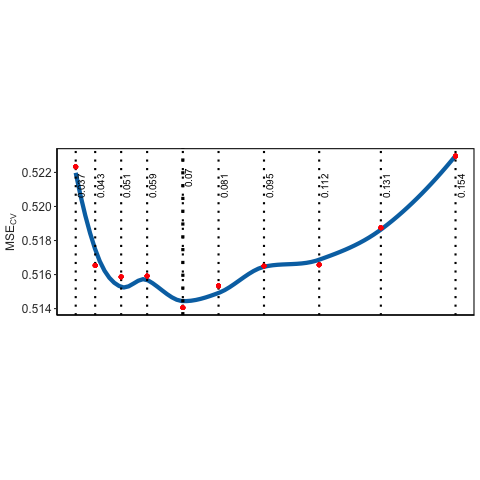

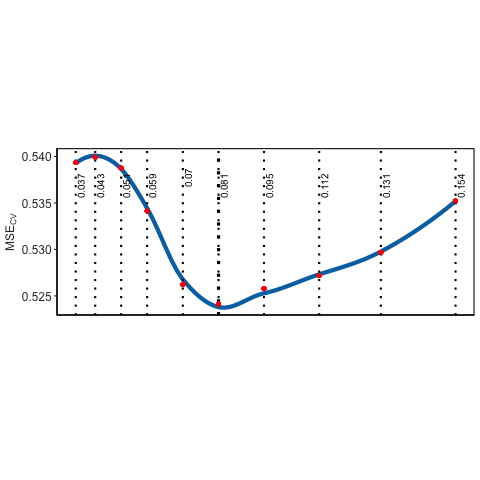

In [316]:
%%R -i RH_mse_lasso_df,LH_mse_lasso_df

print(plt_mse(RH_mse_lasso_df, show_all_alphas=TRUE))
print(plt_mse(LH_mse_lasso_df, show_all_alphas=TRUE))

In [317]:
#### Import lasso csv files for plotting ####

## Depth ##
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_all_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_all_lasso_df.csv")

### Plot LASSO Results
If there are too many alpha values in the graphs below and it makes the graphs crowded, simply change the alpha values that you feed into the LASSO models above.

In [318]:
alpha_min_RH = RH_mse_lasso_df[RH_mse_lasso_df['MSE'] == min(RH_mse_lasso_df['MSE'])]['alpha']
alpha_min_LH = LH_mse_lasso_df[LH_mse_lasso_df['MSE'] == min(LH_mse_lasso_df['MSE'])]['alpha']

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
quartz_off_screen 
                2 


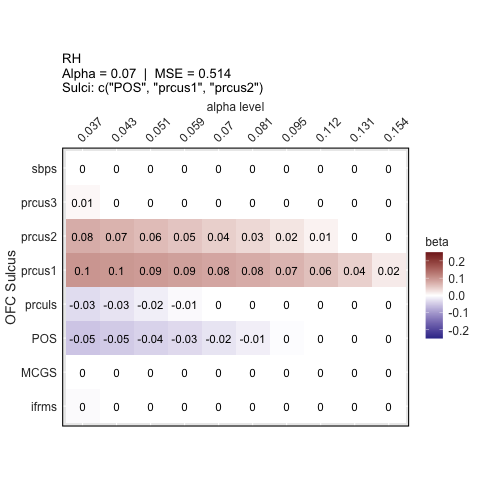

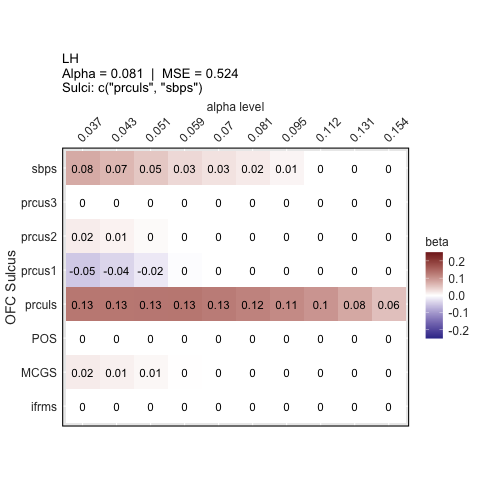

In [319]:
%%R -i RH_mse_lasso_df,RH_all_lasso_df,LH_mse_lasso_df,LH_all_lasso_df -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

# RH 
alpha_min_RH = RH_mse_lasso_df$alpha[RH_mse_lasso_df$MSE == min(RH_mse_lasso_df$MSE)]
mse_val_RH = RH_all_lasso_df$MSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "RH 
Alpha = ", as.character(alpha_min_RH), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH 
alpha_min_LH = LH_mse_lasso_df$alpha[LH_mse_lasso_df$MSE == min(LH_mse_lasso_df$MSE)]
mse_val_LH = LH_all_lasso_df$MSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "LH 
Alpha = ", as.character(alpha_min_LH), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))

### SAVE OUT
# RH
ragg::agg_tiff("results/PMC_RH_dpth_lasso_plt.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(RH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/PMC_RH_dpth_mse_plt.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(RH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()
# LH
ragg::agg_tiff("results/PMC_LH_dpth_lasso_plt.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(LH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/PMC_LH_dpth_mse_plt.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(LH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()

Model summary and evaluation

In [320]:
alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_cv(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_cv(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

In [321]:
# zip up the sulcal labels with corresponding coefficient values
labels = results_dict_rh['best_grid_features']
measurements = results_dict_rh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_RH = list(zip(labels, filtered_measurements))

labels = results_dict_lh['best_grid_features']
measurements = results_dict_lh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_LH = list(zip(labels, filtered_measurements))


### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
MSE at optimal alpha:     {results_dict_rh['final_mse']}
Selected coefficients: 
{sulc_betas_RH}
      ''')

print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()

### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
MSE at optimal alpha:     {results_dict_lh['final_mse']}
Selected coefficients: 
{sulc_betas_LH}
      ''')

RH LASSO Regression predicting Factor_FeelingsTrigger: 

Optimal alpha value:      {'alpha': [0.07]}
R^2 at optimal alpha:     0.01804345076859315
MSE at optimal alpha:     0.50216647117633
Selected coefficients: 
[('POS', -0.024471716860014963), ('prcus1', 0.08206487988082768), ('prcus2', 0.04325825863389825)]
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting Factor_FeelingsTrigger: 

Optimal alpha value:      {'alpha': [0.081]}
R^2 at optimal alpha:     0.033554947521362455
MSE at optimal alpha:     0.5158506777783612
Selected coefficients: 
[('prculs', 0.11888793348117925), ('sbps', 0.018186135984136105)]
      


100%|█████████████████████████████████████████████| 5000/5000 [08:47<00:00,  9.47it/s]


Original RH MSE: 0.50216647117633
Permuted (exact) p-value: 0.1684



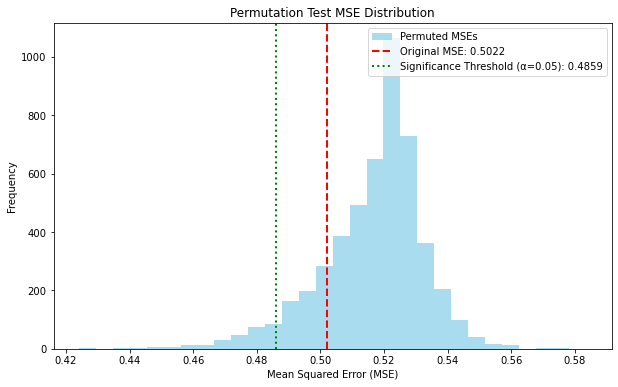

In [68]:
### RIGHT HEMISPHERE PMC PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_RH_df[X_sulc], 
                                                            lasso_RH_df[beh_var],
                                                            alpha_dict_vf_RH,
                                                            lasso_cv, n_permutations=5000)
print("Original RH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

100%|█████████████████████████████████████████████| 5000/5000 [08:54<00:00,  9.35it/s]


Original LH MSE: 0.5158506777783612
Permuted (exact) p-value: 0.0964



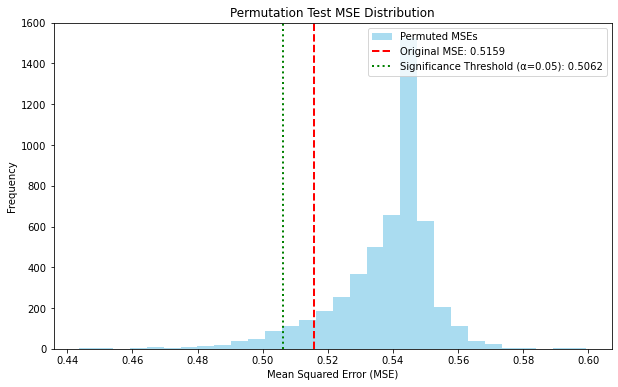

In [69]:
### LEFT HEMISPHERE PMC PERMUTATIONS: TIME WARNING!!
# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_LH_df[X_sulc], 
                                                            lasso_LH_df[beh_var],
                                                            alpha_dict_vf_LH,
                                                            lasso_cv, n_permutations=5000)
print("Original LH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

Spearman correlation: measured vs. predicted

In [322]:
preds_df_RH = results_dict_rh['model_preds_df'].loc[:, 'Measured':]
preds_df_LH = results_dict_lh['model_preds_df'].loc[:, 'Measured':]

corr_RH, p_val_RH = spearmanr(preds_df_RH['Measured'], preds_df_RH['Predicted'])
corr_LH, p_val_LH = spearmanr(preds_df_LH['Measured'], preds_df_LH['Predicted'])

print(corr_RH, p_val_RH)
print(corr_LH, p_val_LH)

0.21364204265013426 0.03763347034738839
0.1607398227764729 0.11575896262679002


`geom_smooth()` using formula = 'y ~ x'


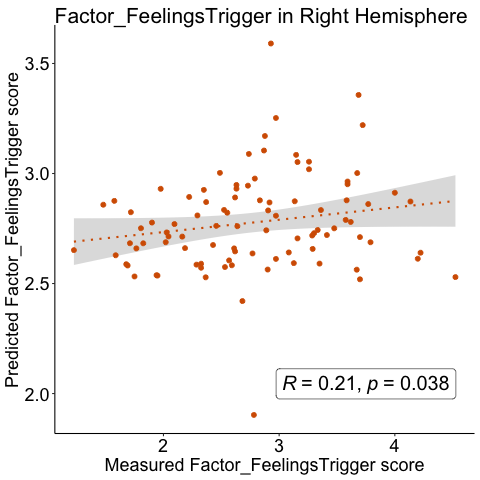

In [323]:
%%R -i preds_df_RH,beh_var
### RIGHT HEMISPHERE
scatter = ggplot(preds_df_RH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Right Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

`geom_smooth()` using formula = 'y ~ x'


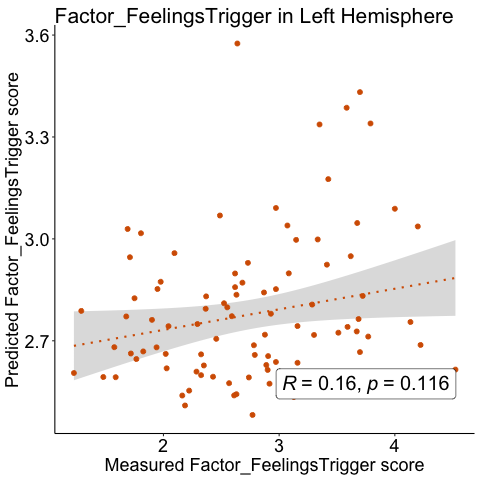

In [324]:
%%R -i preds_df_LH,beh_var
### LEFT HEMISPHERE
scatter = ggplot(preds_df_LH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Left Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

In [325]:
# Assuming preds_df_RH and preds_df_LH are your dataframes for right and left hemispheres respectively
original_corr_RH, p_value_RH, shuffled_cors_RH = permutation_test_spearman(preds_df_RH, n_permutations=5000)
original_corr_LH, p_value_LH, shuffled_cors_LH = permutation_test_spearman(preds_df_LH, n_permutations=5000)
# Output results
print(f"Right Hemisphere: Original Spearman Correlation: {original_corr_RH}, Permuted p-value: {p_value_RH}")
print(f"Left Hemisphere:  Original Spearman Correlation: {original_corr_LH}, Permuted p-value: {p_value_LH}")

100%|███████████████████████████████████████████| 5000/5000 [00:01<00:00, 3070.92it/s]

Right Hemisphere: Original Spearman Correlation: 0.21364204265013426, Permuted p-value: 0.0194
Left Hemisphere:  Original Spearman Correlation: 0.1607398227764729, Permuted p-value: 0.0648


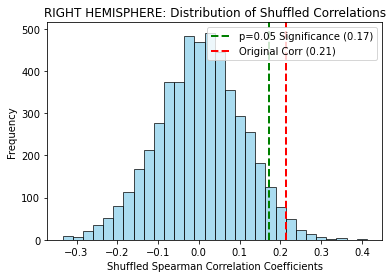

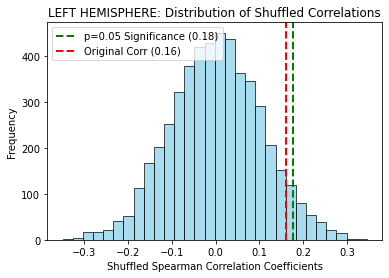

In [326]:
# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_RH = np.sort(shuffled_cors_RH)
threshold_index = int(len(sorted_shuffled_cors_RH) * 0.95)
significance_threshold = sorted_shuffled_cors_RH[threshold_index]

# Create histogram
plt.hist(shuffled_cors_RH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_RH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_RH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('RIGHT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_LH = np.sort(shuffled_cors_LH)

threshold_index = int(len(sorted_shuffled_cors_LH) * 0.95)
significance_threshold = sorted_shuffled_cors_LH[threshold_index]


# Create histogram
plt.hist(sorted_shuffled_cors_LH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_LH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_LH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('LEFT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

### AIC Comparison
First we calculate AIC scores from each of our models. Remember that with AIC, LOWER is better.

In [327]:
# run FTA PMC lasso regressions again to make sure we're dealing with FTA LASSO and not something else
alpha_dict_vf_RH = {'alpha': [.07]}
alpha_dict_vf_LH = {'alpha': [.081]}

results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df['Factor_FeelingsTrigger'], alpha_dict_vf_RH)
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df['Factor_FeelingsTrigger'], alpha_dict_vf_LH)

In [328]:
### get MSE for each model

## FTA depth models
rh_lasso_mse = results_dict_rh['final_mse']
lh_lasso_mse = results_dict_lh['final_mse']
print(f'RH MSE: {rh_lasso_mse}')
print(f'LH MSE: {lh_lasso_mse}')

# Selected sulci
rh_fta_depth_sulc = ['POS', 'prcus1', 'prcus2']
lh_fta_depth_sulc = ['prculs', 'sbps']

RH MSE: 0.5147304759551141
LH MSE: 0.5239637552094702


In [329]:
## AIC from RH Lasso model ##
# n = sample size (this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression))
# number of params = (# of sulci) + intercept
n = 95  # this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression)
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_pmc = calculate_aic(n, rh_lasso_mse, num_params)
print(AIC_rh_pmc)

print()

## AIC from LH Lasso model ##
n = 97
num_params = len(lh_fta_depth_sulc) + 1
AIC_lh_pmc = calculate_aic(n, lh_lasso_mse, num_params)
print(AIC_lh_pmc)

-55.090626982393125

-56.694278350595766


###### Note that a negative delta AIC simply indicates that you need to flip the subtraction around (i.e. the model you thought was better is actually worse.)

In [330]:
# lower AIC is better. AIC delta>2 is an interpretable difference. delta>10 is substantial

# OFC depth lasso AIC scores were calculated earlier
AIC_rh_ofc = -65.30881426454658
AIC_lh_ofc = -65.85722623777328


print("RH Models: PMC - OFC")
delta_AIC_rh = AIC_rh_pmc - AIC_rh_ofc
print('''
RH_PMC AIC         = {}
RH_OFC AIC         = {}
Delta                    = {}
'''.format(AIC_rh_all, AIC_rh_pmc, delta_AIC_rh))

print()

print("LH Models: PMC - OFC")
delta_AIC_lh = AIC_lh_pmc - AIC_lh_ofc
print('''
RH_PMC AIC         = {}
RH_OFC AIC         = {}
Delta                    = {}
'''.format(AIC_lh_pmc, AIC_lh_ofc, delta_AIC_lh))

RH Models: PMC - OFC

RH_PMC AIC         = -45.768116788626564
RH_OFC AIC         = -55.090626982393125
Delta                    = 10.218187282153458


LH Models: PMC - OFC

RH_PMC AIC         = -56.694278350595766
RH_OFC AIC         = -65.85722623777328
Delta                    = 9.16294788717751



## Nested LASSO

In [331]:
#### RUN LASSO and get all beta coefficients ####

### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]
# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis_fully_nested(file_label = label,
                        sulc_df = data,
                        X_inds = X_sulc,
                        y_dep = beh_var,
                        alphas = alphas,
                        model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 95

Alpha values: {'alpha': [0.037, 0.043, 0.051, 0.059, 0.07, 0.081, 0.095, 0.112, 0.131, 0.154]}

Predictors: ['POS', 'prculs', 'prcus1', 'prcus2', 'prcus3', 'sbps', 'MCGS', 'ifrms']

depth_RH_Factor_FeelingsTrigger
Here's the data you're working with:


,sub,hemi,Factor_FeelingsTrigger,POS,prculs,prcus1,prcus2,prcus3,sbps,MCGS,ifrms
1,103,rh,2.738095,1.092140,0.943864,0.854365,0.858799,0.869410,0.798001,1.861209,1.012736
3,111,rh,2.186508,1.224781,0.471314,0.536848,0.556452,0.556246,0.607166,0.716609,0.693046
5,115,rh,2.900794,1.450866,0.511168,0.463499,0.562163,0.508694,1.163468,1.233377,0.511168
7,118,rh,3.698413,1.287615,0.653605,0.444447,0.502389,0.467033,0.483951,0.900275,0.457003
9,121,rh,4.222222,1.018108,0.619881,0.464194,0.616527,0.427604,0.678716,1.103963,0.421270



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 97

Alpha values: {'alpha': [0.037, 0.043, 0.051, 0.059, 0.07, 0.081, 0.095, 0.112, 0.131, 0.154]}

Predictors: ['POS', 'prculs', 'prcus1', 'prcus2', 'prcus3', 'sbps', 'MCGS', 'ifrms']

depth_LH_Factor_FeelingsTrigger
Here's the data you're working with:


,sub,hemi,Factor_FeelingsTrigger,POS,prculs,prcus1,prcus2,prcus3,sbps,MCGS,ifrms
0,103,lh,2.738095,1.109544,0.489121,0.470415,0.497050,0.466798,0.525880,1.767742,0.503455
2,111,lh,2.186508,0.646218,0.434769,0.404289,0.433193,0.467732,0.452144,0.780127,0.409573
4,115,lh,2.900794,0.648261,0.500014,0.495566,0.567847,0.522283,0.551476,0.650425,0.615514
6,118,lh,3.698413,0.509853,0.560307,0.517827,0.513387,0.541792,0.549500,0.809596,0.587855
8,121,lh,4.222222,1.171465,0.577971,0.809882,0.572429,0.529449,0.564436,0.931088,0.492481



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.69s/it]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [332]:
os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename, '_all_lasso_df_median.csv')

'/Users/josephkelly/Documents/Documents_Primary/Labs/Github/pmc_face/ofc_imp_analysis/Hastings_OFC_BenUpdate/Hastings_OFC_6_26_24/lasso_output/CSVs/fully_nested/depth_RH_Factor_FeelingsTrigger/_all_lasso_df_median.csv'

In [333]:
#### Import lasso csv files for plotting and calculate median betas and MSE's from all folds ####
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_mse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_mse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df.csv")

# Calculate median values for beta coefficients and MSE
median_betas_RH = RH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_MSE_RH = RH_all_lasso_df.groupby('alpha_level')['MSE'].median().reset_index()
median_betas_LH = LH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_MSE_LH = LH_all_lasso_df.groupby('alpha_level')['MSE'].median().reset_index()
# Merge the two 'all' dataframes on 'alpha_level'
RH_all_lasso_df = pd.merge(median_betas_RH, median_MSE_RH, on='alpha_level', how='left')
LH_all_lasso_df = pd.merge(median_betas_LH, median_MSE_LH, on='alpha_level', how='left')
# Group mse df by alpha value
RH_mse_lasso_df = RH_mse_lasso_df.groupby('alpha')['MSE'].median().reset_index()
LH_mse_lasso_df = LH_mse_lasso_df.groupby('alpha')['MSE'].median().reset_index()

RH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_all_lasso_df_median.csv'), index=False)
LH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_all_lasso_df_median.csv'), index=False)
RH_mse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_mse_lasso_df_median.csv'), index=False)
LH_mse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_mse_lasso_df_median.csv'), index=False)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


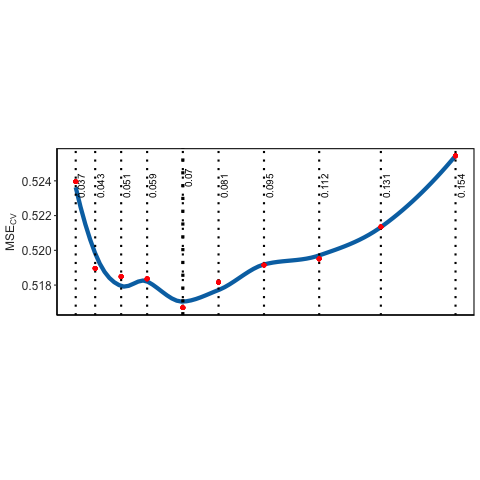

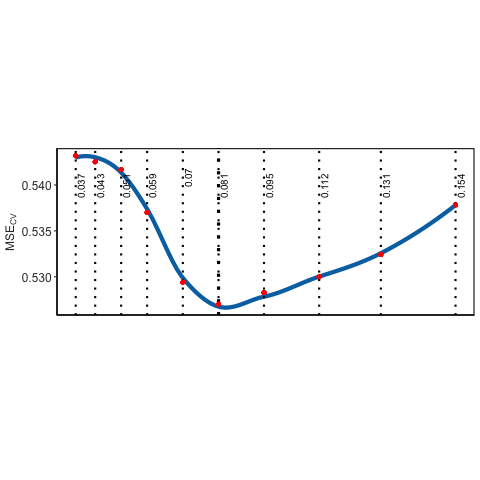

In [334]:
%%R -i RH_mse_lasso_df,LH_mse_lasso_df
print(plt_mse(RH_mse_lasso_df, show_all_alphas=TRUE))
print(plt_mse(LH_mse_lasso_df, show_all_alphas=TRUE))

In [335]:
#### Import lasso csv files for plotting ####
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_mse_lasso_df_median.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df_median.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_mse_lasso_df_median.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df_median.csv")

Plot LASSO Results

In [336]:
alpha_min_RH = RH_mse_lasso_df[RH_mse_lasso_df['MSE'] == min(RH_mse_lasso_df['MSE'])]['alpha']

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
quartz_off_screen 
                2 


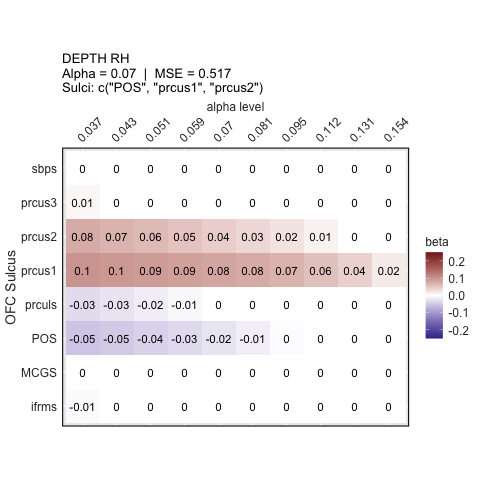

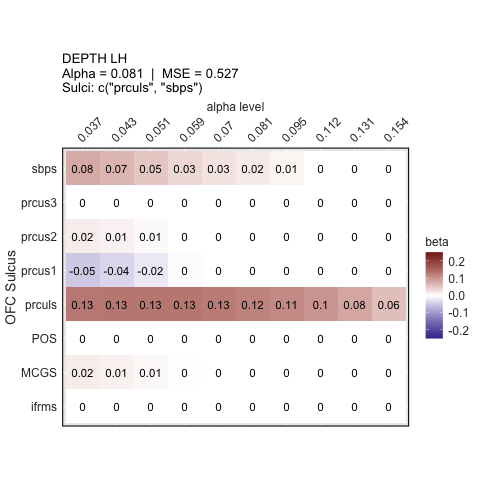

In [337]:
%%R -i RH_mse_lasso_df,RH_all_lasso_df,LH_mse_lasso_df,LH_all_lasso_df -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

# RH 
alpha_min_RH = RH_mse_lasso_df$alpha[RH_mse_lasso_df$MSE == min(RH_mse_lasso_df$MSE)]
mse_val_RH = RH_all_lasso_df$MSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH RH
Alpha = ", as.character(alpha_min_RH), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH 
alpha_min_LH = LH_mse_lasso_df$alpha[LH_mse_lasso_df$MSE == min(LH_mse_lasso_df$MSE)]
mse_val_LH = LH_all_lasso_df$MSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH LH
Alpha = ", as.character(alpha_min_LH), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))

### SAVE OUT
# RH
ragg::agg_tiff("results/PMC_RH_dpth_lasso_plt_NESTED.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(RH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/PMC_RH_dpth_mse_plt_NESTED.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(RH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()
# LH
ragg::agg_tiff("results/PMC_LH_dpth_lasso_plt_NESTED.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(LH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/PMC_LH_dpth_mse_plt_NESTED.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(LH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()

Model summary and evaluation

In [338]:
alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

Sulcus Statistics for RH:
   Sulcus  Count  Percentage Hemisphere
0     POS     94   98.947368         RH
1  prcus1     95  100.000000         RH
2  prcus2     95  100.000000         RH
3  prculs      9    9.473684         RH
4  prcus3      2    2.105263         RH

Sulcus Statistics for LH:
   Sulcus  Count  Percentage Hemisphere
0  prculs     97  100.000000         LH
1    sbps     92   94.845361         LH
2    MCGS      1    1.030928         LH
3  prcus2      1    1.030928         LH
4  prcus1      1    1.030928         LH



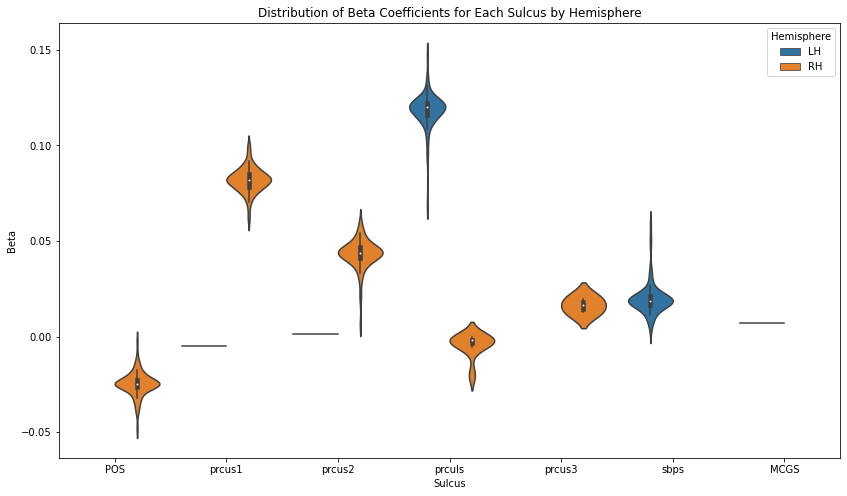

Medians for each Sulcus in the Right Hemisphere:
POS      -0.025
prcus1    0.082
prcus2    0.044
dtype: float64

Medians for each Sulcus in the Left Hemisphere:
prculs    0.120
sbps      0.018
dtype: float64


In [339]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have data for both hemispheres
df_RH = pd.DataFrame(results_dict_rh['sulc_beta_dicts'])
df_LH = pd.DataFrame(results_dict_lh['sulc_beta_dicts'])

# Add Hemisphere column to differentiate the data
df_RH['Hemisphere'] = 'RH'
df_LH['Hemisphere'] = 'LH'
df_combined = pd.concat([df_RH, df_LH], ignore_index=True)

# Calculate counts and percentages separately for each hemisphere
sulcus_counts_RH = df_RH.drop(columns='Hemisphere').count()
sulcus_counts_LH = df_LH.drop(columns='Hemisphere').count()
total_dicts_RH = len(df_RH)
total_dicts_LH = len(df_LH)
sulcus_percentage_RH = (sulcus_counts_RH / total_dicts_RH) * 100
sulcus_percentage_LH = (sulcus_counts_LH / total_dicts_LH) * 100

# Create DataFrames for each hemisphere's statistics
sulcus_stats_RH = pd.DataFrame({
    'Sulcus': sulcus_counts_RH.index,
    'Count': sulcus_counts_RH.values,
    'Percentage': sulcus_percentage_RH.values,
    'Hemisphere': 'RH'
})
sulcus_stats_LH = pd.DataFrame({
    'Sulcus': sulcus_counts_LH.index,
    'Count': sulcus_counts_LH.values,
    'Percentage': sulcus_percentage_LH.values,
    'Hemisphere': 'LH'
})

print("Sulcus Statistics for RH:")
print(sulcus_stats_RH)
print()
print("Sulcus Statistics for LH:")
print(sulcus_stats_LH)
print()

# Melt the combined DataFrame for easier plotting
df_melted = df_combined.melt(id_vars='Hemisphere', var_name='Sulcus', value_name='Beta')

# Plotting
plt.figure(figsize=(14, 8))
sns.violinplot(x='Sulcus', y='Beta', hue='Hemisphere', data=df_melted, hue_order=['LH', 'RH'])
plt.title('Distribution of Beta Coefficients for Each Sulcus by Hemisphere')
plt.show()

# Calculate and print medians for each hemisphere separately (ONLY FOR SULCI SELECTED >50% OF THE TIME)
df_RH_numeric = df_RH.select_dtypes(include=[np.number])
df_LH_numeric = df_LH.select_dtypes(include=[np.number])
medians_RH = df_RH_numeric.loc[:, df_RH_numeric.count() > total_dicts_RH / 2].median().round(3)
medians_LH = df_LH_numeric.loc[:, df_LH_numeric.count() > total_dicts_LH / 2].median().round(3)
print("Medians for each Sulcus in the Right Hemisphere:")
print(medians_RH)
print()
print("Medians for each Sulcus in the Left Hemisphere:")
print(medians_LH)


In [340]:
# Print all results

### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
MSE at optimal alpha:     {results_dict_rh['final_mse']}
Selected coefficients (median): 
{medians_RH}
      ''')
print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()
### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
MSE at optimal alpha:     {results_dict_lh['final_mse']}
Selected coefficients (median): 
{medians_LH}
      ''')

RH LASSO Regression predicting Factor_FeelingsTrigger: 

Optimal alpha value:      {'alpha': [0.07]}
R^2 at optimal alpha:     -0.006524710359730568
MSE at optimal alpha:     0.5147304759551141
Selected coefficients (median): 
POS      -0.025
prcus1    0.082
prcus2    0.044
dtype: float64
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting Factor_FeelingsTrigger: 

Optimal alpha value:      {'alpha': [0.081]}
R^2 at optimal alpha:     0.01835511570677617
MSE at optimal alpha:     0.5239637552094702
Selected coefficients (median): 
prculs    0.120
sbps      0.018
dtype: float64
      


100%|███████████████████████████████████████████| 5000/5000 [3:47:57<00:00,  2.74s/it]


Original RH MSE: 0.5147304759551141
Permuted (exact) p-value: 0.1278



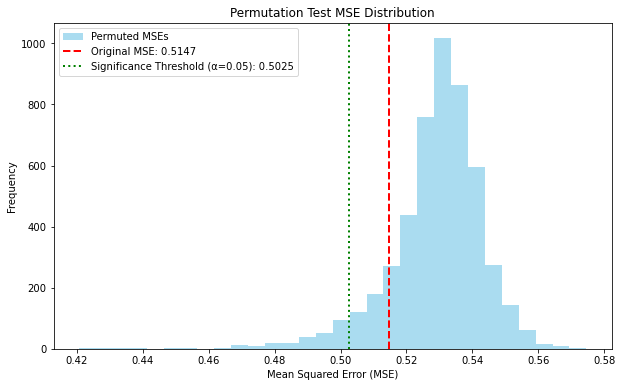

In [102]:
### RIGHT HEMISPHERE PMC PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_RH_df[X_sulc], 
                                                            lasso_RH_df[beh_var],
                                                            alpha_dict_vf_RH,
                                                            lasso_fully_nested, n_permutations=5000)

print("Original RH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

100%|███████████████████████████████████████████| 5000/5000 [4:01:17<00:00,  2.90s/it]


Original LH MSE: 0.5239637552094702
Permuted (exact) p-value: 0.0416



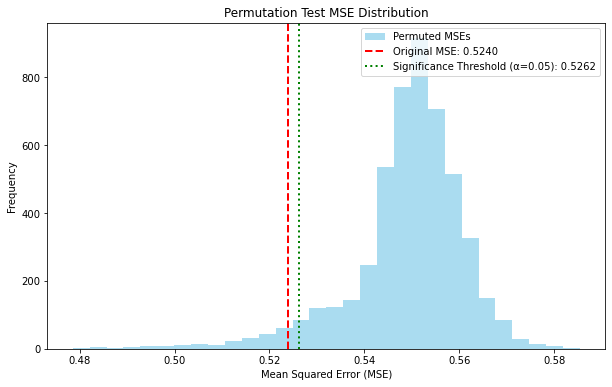

In [103]:
### LEFT HEMISPHERE PMC PERMUTATIONS: TIME WARNING!!

# Assuming lasso_cv is your model function and lasso_RH_df[X_sulc], lasso_RH_df[beh_var] are your predictors and outcome
original_mse, p_value, permuted_mses  = permutation_test_mse(lasso_LH_df[X_sulc], 
                                                            lasso_LH_df[beh_var],
                                                            alpha_dict_vf_LH,
                                                            lasso_fully_nested, n_permutations=5000)

print("Original LH MSE:", original_mse)
print("Permuted (exact) p-value:", p_value)
print()
# Now plot the results
plot_permutation_mse_results(permuted_mses, original_mse, alpha=0.05)

Spearman correlation analysis

In [341]:
preds_df_RH = results_dict_rh['final_model_preds_df'].loc[:, 'Measured':]
preds_df_LH = results_dict_lh['final_model_preds_df'].loc[:, 'Measured':]

corr_RH, p_val_RH = spearmanr(preds_df_RH['Measured'], preds_df_RH['Predicted'])
corr_LH, p_val_LH = spearmanr(preds_df_LH['Measured'], preds_df_LH['Predicted'])

print(corr_RH, p_val_RH)
print(corr_LH, p_val_LH)

0.04769920458199007 0.6462190052421402
0.0807940009930584 0.43145728798319094


`geom_smooth()` using formula = 'y ~ x'


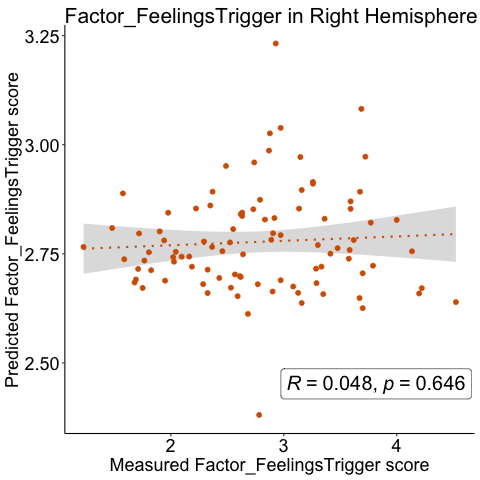

In [342]:
%%R -i preds_df_RH,beh_var
### RIGHT HEMISPHERE
scatter = ggplot(preds_df_RH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Right Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

`geom_smooth()` using formula = 'y ~ x'


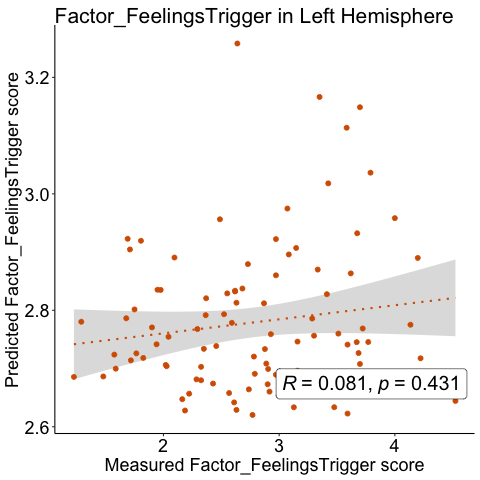

In [343]:
%%R -i preds_df_LH,beh_var
### LEFT HEMISPHERE
scatter = ggplot(preds_df_LH, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
  labs(title = paste(beh_var, "in Left Hemisphere")) +
  xlab(paste("Measured", beh_var, "score")) +
  ylab(paste("Predicted", beh_var, "score")) +
  theme(plot.title = element_text(size=21))

In [344]:
# Assuming preds_df_RH and preds_df_LH are your dataframes for right and left hemispheres respectively
original_corr_RH, p_value_RH, shuffled_cors_RH = permutation_test_spearman(preds_df_RH, n_permutations=5000)
original_corr_LH, p_value_LH, shuffled_cors_LH = permutation_test_spearman(preds_df_LH, n_permutations=5000)
# Output results
print(f"Right Hemisphere: Original Spearman Correlation: {original_corr_RH}, Permuted p-value: {p_value_RH}")
print(f"Left Hemisphere:  Original Spearman Correlation: {original_corr_LH}, Permuted p-value: {p_value_LH}")

100%|███████████████████████████████████████████| 5000/5000 [00:01<00:00, 2975.06it/s]

Right Hemisphere: Original Spearman Correlation: 0.04769920458199007, Permuted p-value: 0.323
Left Hemisphere:  Original Spearman Correlation: 0.0807940009930584, Permuted p-value: 0.2114


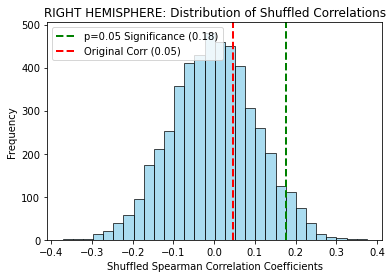

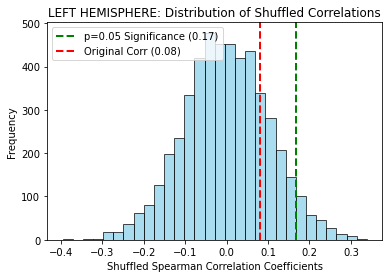

In [345]:
# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_RH = np.sort(shuffled_cors_RH)
threshold_index = int(len(sorted_shuffled_cors_RH) * 0.95)
significance_threshold = sorted_shuffled_cors_RH[threshold_index]
# Create histogram
plt.hist(shuffled_cors_RH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_RH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_RH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('RIGHT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

# Sort the shuffled correlations and find the 95th percentile for p=0.05 significance
sorted_shuffled_cors_LH = np.sort(shuffled_cors_LH)
threshold_index = int(len(sorted_shuffled_cors_LH) * 0.95)
significance_threshold = sorted_shuffled_cors_LH[threshold_index]
# Create histogram
plt.hist(sorted_shuffled_cors_LH, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=significance_threshold, color='green', linestyle='--', linewidth=2, label=f'p=0.05 Significance ({significance_threshold:.2f})')
plt.axvline(x=original_corr_LH, color='red', linestyle='--', linewidth=2, label=f'Original Corr ({original_corr_LH:.2f})')
plt.xlabel('Shuffled Spearman Correlation Coefficients')
plt.ylabel('Frequency')
plt.title('LEFT HEMISPHERE: Distribution of Shuffled Correlations')
plt.legend()
plt.show()

### AIC Comparison
First we calculate AIC scores from each of our models. Remember that with AIC, LOWER is better.

In [346]:
# run FTA PMC lasso regressions again to make sure we're dealing with FTA LASSO and not something else
alpha_dict_vf_RH = {'alpha': [.07]}
alpha_dict_vf_LH = {'alpha': [.081]}

results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df['Factor_FeelingsTrigger'], alpha_dict_vf_RH)
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df['Factor_FeelingsTrigger'], alpha_dict_vf_LH)

In [347]:
### get MSE for each model

## FTA depth models
rh_lasso_mse = results_dict_rh['final_mse']
lh_lasso_mse = results_dict_lh['final_mse']
print(f'RH MSE: {rh_lasso_mse}')
print(f'LH MSE: {lh_lasso_mse}')

# Selected sulci
rh_fta_depth_sulc = ['POS', 'prcus1', 'prcus2']
lh_fta_depth_sulc = ['prculs', 'sbps']

RH MSE: 0.5147304759551141
LH MSE: 0.5239637552094702


In [348]:
## AIC from RH Lasso model ##
# n = sample size (this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression))
# number of params = (# of sulci) + intercept
n = 95  # this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression)
num_params = len(rh_fta_depth_sulc) + 1
AIC_rh_pmc = calculate_aic(n, rh_lasso_mse, num_params)
print(AIC_rh_pmc)

print()

## AIC from LH Lasso model ##
n = 97
num_params = len(lh_fta_depth_sulc) + 1
AIC_lh_pmc = calculate_aic(n, lh_lasso_mse, num_params)
print(AIC_lh_pmc)

-55.090626982393125

-56.694278350595766


###### Note that a negative delta AIC simply indicates that you need to flip the subtraction around (i.e. the model you thought was better is actually worse.)

In [349]:
# lower AIC is better. AIC delta>2 is an interpretable difference. delta>10 is substantial

# OFC depth lasso AIC scores were calculated earlier
AIC_rh_ofc = -63.53346113575698
AIC_lh_ofc = -61.42314752602792


print("RH Models: PMC - OFC")
delta_AIC_rh = AIC_rh_pmc - AIC_rh_ofc
print('''
RH_PMC AIC         = {}
RH_OFC AIC         = {}
Delta                    = {}
'''.format(AIC_rh_all, AIC_rh_pmc, delta_AIC_rh))

print()

print("LH Models: PMC - OFC")
delta_AIC_lh = AIC_lh_pmc - AIC_lh_ofc
print('''
LH_PMC AIC         = {}
LH_OFC AIC         = {}
Delta                    = {}
'''.format(AIC_lh_pmc, AIC_lh_ofc, delta_AIC_lh))

RH Models: PMC - OFC

RH_PMC AIC         = -45.768116788626564
RH_OFC AIC         = -55.090626982393125
Delta                    = 8.442834153363854


LH Models: PMC - OFC

LH_PMC AIC         = -56.694278350595766
LH_OFC AIC         = -61.42314752602792
Delta                    = 4.728869175432152



# COLFS LASSO

In [350]:
### Paths to sulc_morphology CSV and behavioral CSV
sulc_df_path = working_dir + "/data/tertiary_depth_lasso_colfs.csv"
# sulc_df_path = working_dir + "/data/tertiary_ct_lasso_colfs.csv"

morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'

morph_df_import = pd.read_csv(sulc_df_path)
morph_df = morph_df_import.sort_values(by = "sub").reset_index(drop=True)

morph_df = morph_df.loc[:, ~morph_df.columns.isin(["Unnamed: 0"])]
morph_df.head()


,sub,hemi,pif,lft,fta,colfs,mosp,mosa,tos,losa,losp,sf
0,103,lh,4.888889,3.288889,2.738095,0.020820,0.043437,0.027705,0.277640,0.092684,-0.040952,-0.043463
1,103,rh,4.888889,3.288889,2.738095,0.018962,0.083681,0.019753,0.284077,-0.158906,0.106147,-0.050473
2,111,lh,3.611111,2.216667,2.186508,-0.016786,0.052756,0.039208,0.248951,-0.036932,-0.045451,-0.033671
3,111,rh,3.611111,2.216667,2.186508,0.028683,0.171853,0.159984,0.346033,-0.104421,0.031968,0.045069
4,115,lh,2.888889,2.722222,2.900794,-0.053165,0.181577,0.098441,0.386163,-0.145578,0.062939,-0.132194


### Data Processing

In [351]:
sulc_list = ['colfs', 'losa', 'losp', 'mosp', 'tos', 'mosa', 'sf']

# Create dataframes for analysis
subset_fta_df = morph_df[['sub', 'hemi', 'fta'] + sulc_list].dropna()
fta_RH_df = subset_fta_df[(subset_fta_df['hemi'] == 'rh')] 
fta_LH_df = subset_fta_df[(subset_fta_df['hemi'] == 'lh')]

subset_pif_df = morph_df[['sub', 'hemi', 'pif'] + sulc_list].dropna()
pif_RH_df = subset_pif_df[(subset_pif_df['hemi'] == 'rh')]
pif_LH_df = subset_pif_df[(subset_pif_df['hemi'] == 'lh')]

subset_lft_df = morph_df[['sub', 'hemi', 'lft'] + sulc_list].dropna()
lft_RH_df = subset_lft_df[(subset_lft_df['hemi'] == 'rh')]
lft_LH_df = subset_lft_df[(subset_lft_df['hemi'] == 'lh')]

In [352]:
# Specify dataframes for LASSO
beh_var = 'fta'
lasso_RH_df = fta_RH_df
lasso_LH_df = fta_LH_df
# beh_var = 'pif'
# lasso_RH_df = pif_RH_df
# lasso_LH_df = pif_LH_df
# beh_var = 'lft'
# lasso_RH_df = lft_RH_df
# lasso_LH_df = lft_LH_df

# Names of files that will hold LASSO results
LH_filename = morph_name + '_LH_' + beh_var + '_COLFS'
RH_filename = morph_name + '_RH_' + beh_var + '_COLFS'

### Lists of alpha values to try for each dataset
## For when things were unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-4, -1.7, 15).tolist()] # depth FTA unscaled
# alpha_list_RH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_LH = [round(num, 4) for num in [.005]] # depth FTA old unscaled
# alpha_list_RH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# alpha_list_LH = [round(num, 4) for num in np.logspace(-3, -1, 25).tolist()] # thickness FTA unscaled
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
## Now that things are scaled
# alpha_list_RH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-2.3, -0.6, 10).tolist()] # depth FTA
alpha_list_RH = [round(num, 3) for num in np.logspace(-2.3, -.9, 10).tolist()] # depth FTA
alpha_list_LH = [round(num, 3) for num in np.logspace(-2.3, -.85, 10).tolist()]  # depth FTA
# alpha_list_RH = [round(num, 3) for num in np.logspace(-3, -0.8, 12).tolist()] # thickness FTA
# alpha_list_LH = [round(num, 3) for num in np.logspace(-3, -0.8, 12).tolist()] # thickness FTA
# depth PIF
# depth PIF
# thickness PIF
# thickness PIF

# ==================================================
RH_alphas = {'alpha': alpha_list_RH}  
LH_alphas = {'alpha': alpha_list_LH}  

### LASSO

LASSO for feature selection - which sulci should be included in a model

In [353]:
#### RUN LASSO and get all beta coefficients ####
### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]

# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis(file_label = label,
                   sulc_df = data,
                   X_inds = X_sulc,
                   y_dep = beh_var,
                   alphas = alphas,
                   model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 102

Alpha values: {'alpha': [0.005, 0.007, 0.01, 0.015, 0.021, 0.03, 0.043, 0.062, 0.088, 0.126]}

Predictors: ['colfs', 'losa', 'losp', 'mosp', 'tos', 'mosa', 'sf']

depth_RH_fta_COLFS
Here's the data you're working with:


,sub,hemi,fta,colfs,losa,losp,mosp,tos,mosa,sf
1,103,rh,2.738095,0.018962,-0.158906,0.106147,0.083681,0.284077,0.019753,-0.050473
3,111,rh,2.186508,0.028683,-0.104421,0.031968,0.171853,0.346033,0.159984,0.045069
5,115,rh,2.900794,0.036777,-0.064511,0.012098,0.135569,0.305173,0.021485,0.005142
6,118,rh,3.698413,-0.036223,-0.046666,0.042301,0.116709,0.339726,0.006506,0.100437
8,123,rh,2.591270,0.015961,-0.117570,-0.084043,0.102047,0.295196,0.109633,0.014964



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 109

Alpha values: {'alpha': [0.005, 0.007, 0.011, 0.015, 0.022, 0.032, 0.046, 0.067, 0.097, 0.141]}

Predictors: ['colfs', 'losa', 'losp', 'mosp', 'tos', 'mosa', 'sf']

depth_LH_fta_COLFS
Here's the data you're working with:


,sub,hemi,fta,colfs,losa,losp,mosp,tos,mosa,sf
0,103,lh,2.738095,0.020820,0.092684,-0.040952,0.043437,0.277640,0.027705,-0.043463
2,111,lh,2.186508,-0.016786,-0.036932,-0.045451,0.052756,0.248951,0.039208,-0.033671
4,115,lh,2.900794,-0.053165,-0.145578,0.062939,0.181577,0.386163,0.098441,-0.132194
7,123,lh,2.591270,-0.056908,0.191174,-0.050951,0.119041,0.306877,0.145612,-0.004287
10,124,lh,3.769841,-0.091110,0.118434,-0.033378,0.193081,0.308629,0.090860,-0.055626



RESULTS:



100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [354]:
# import RMSE data that you want
# the CSV will be named the file_label you gave it above + '_rmse_lasso_df.csv'
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


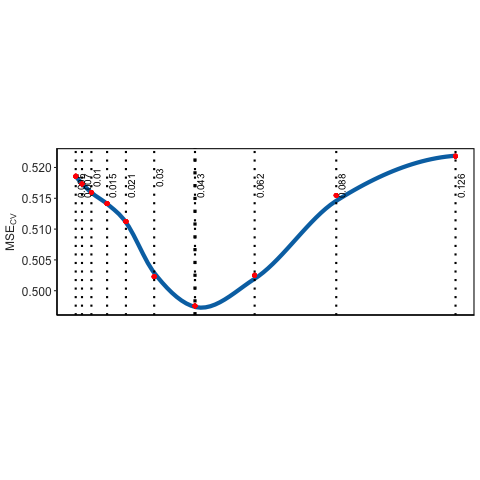

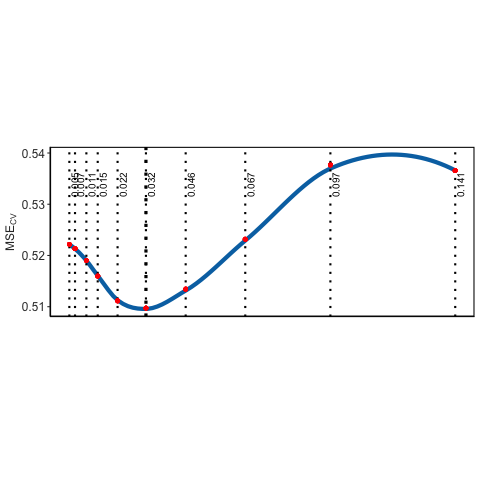

In [355]:
%%R -i RH_mse_lasso_df,LH_mse_lasso_df

print(plt_mse(RH_mse_lasso_df, show_all_alphas=TRUE))
print(plt_mse(LH_mse_lasso_df, show_all_alphas=TRUE))

In [356]:
#### Import lasso csv files for plotting ####

## Depth ##
RH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_mse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + RH_filename + "_all_lasso_df.csv")
LH_mse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_mse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/non_nested/" + LH_filename + "_all_lasso_df.csv")

### Plot LASSO Results
If there are too many alpha values in the graphs below and it makes the graphs crowded, simply change the alpha values that you feed into the LASSO models above.

In [357]:
alpha_min_RH = RH_mse_lasso_df[RH_mse_lasso_df['MSE'] == min(RH_mse_lasso_df['MSE'])]['alpha']
alpha_min_LH = LH_mse_lasso_df[LH_mse_lasso_df['MSE'] == min(LH_mse_lasso_df['MSE'])]['alpha']

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
quartz_off_screen 
                2 


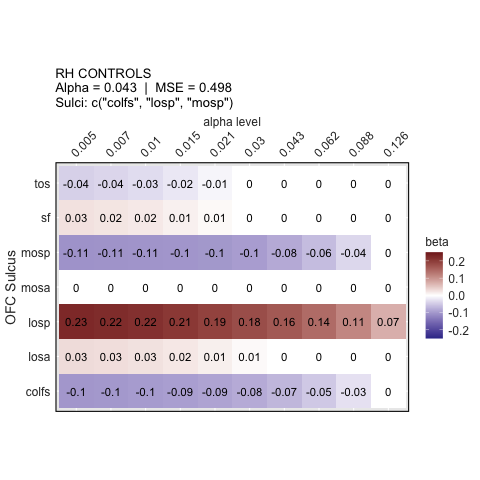

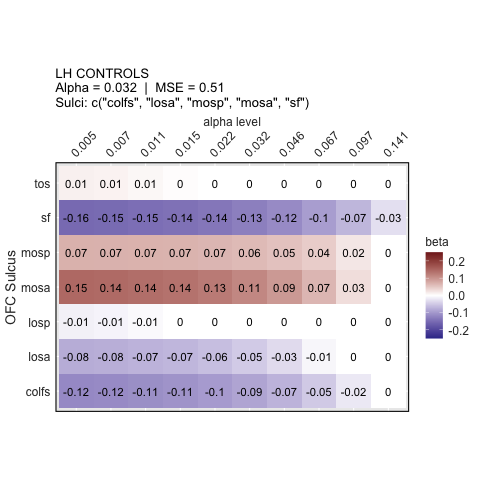

In [358]:
%%R -i RH_mse_lasso_df,RH_all_lasso_df,LH_mse_lasso_df,LH_all_lasso_df -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

# RH CONTROL
alpha_min_RH = RH_mse_lasso_df$alpha[RH_mse_lasso_df$MSE == min(RH_mse_lasso_df$MSE)]
mse_val_RH = RH_all_lasso_df$MSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "RH CONTROLS
Alpha = ", as.character(alpha_min_RH), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH CONTROL
alpha_min_LH = LH_mse_lasso_df$alpha[LH_mse_lasso_df$MSE == min(LH_mse_lasso_df$MSE)]
mse_val_LH = LH_all_lasso_df$MSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "LH CONTROLS
Alpha = ", as.character(alpha_min_LH), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))


### SAVE OUT
# RH
ragg::agg_tiff("results/OFC_RH_dpth_lasso_plt_COLFS.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(RH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_RH_dpth_mse_plt_COLFS.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(RH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()
# LH
ragg::agg_tiff("results/OFC_LH_dpth_lasso_plt_COLFS.tiff", width = 5.85, height = 6.5, units = "in", res = 300)
print(plt_lasso(LH_all_lasso_df))
dev.off()
ragg::agg_tiff("results/OFC_LH_dpth_mse_plt_COLFS.tiff", width = 5, height = 7, units = "in", res = 300)
print(plt_mse(LH_mse_lasso_df, show_all_alphas=FALSE))
dev.off()

### Full Model Summary and Evaluation

In [359]:
alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_cv(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_cv(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

In [360]:
# zip up the sulcal labels with corresponding coefficient values
labels = results_dict_rh['best_grid_features']
measurements = results_dict_rh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_RH = list(zip(labels, filtered_measurements))

labels = results_dict_lh['best_grid_features']
measurements = results_dict_lh['best_model_coef']
filtered_measurements = [m for m in measurements if m != 0]
sulc_betas_LH = list(zip(labels, filtered_measurements))

### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
MSE at optimal alpha:     {results_dict_rh['final_mse']}
Selected coefficients: 
{sulc_betas_RH}
      ''')

print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()

### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
MSE at optimal alpha:     {results_dict_lh['final_mse']}
Selected coefficients: 
{sulc_betas_LH}
      ''')

RH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.043]}
R^2 at optimal alpha:     0.05715263421569128
MSE at optimal alpha:     0.4891832777439733
Selected coefficients: 
[('colfs', -0.06957143075096872), ('losp', 0.16489291639404127), ('mosp', -0.08270621071992257)]
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting fta: 

Optimal alpha value:      {'alpha': [0.032]}
R^2 at optimal alpha:     0.04845294839959202
MSE at optimal alpha:     0.5012475039588536
Selected coefficients: 
[('colfs', -0.08794642188609633), ('losa', -0.0495447796621534), ('mosp', 0.061523667918527494), ('mosa', 0.11363212867815488), ('sf', -0.1289348545707268)]
      
